# Definição do Problema

## Problema
Classificação binária para prever se `total_kills > média_da_liga` com base no draft

## Target
- Binário (1 = acima da média, 0 = abaixo da média de kills da liga)

## Features
- 10 champions do draft
- Times 
- Liga

## Dataset
- 8000+ jogos

## Aplicação
- Apostas ao vivo

## Métricas de Sucesso
- **Primária**: Precision com threshold otimizado
- **Constraint**: Volume de apostas viável  
- **Business**: ROI positivo

## Estratégia de Avaliação
- Precision-Recall curve para threshold ótimo
- Trade-off volume vs precision
- Backtesting com odds simuladas

## Baseline
- Sempre prever classe majoritária
- Random: 50% accuracy

# DATA LOAD

In [148]:
# === CONFIGURAÇÕES INICIAIS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple  
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss


# Configurações de visualização
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Configurações de apostas
ODDS = 1.83
BREAKEVEN_PROBABILITY = 1 / ODDS
THRESHOLDS = np.round(np.arange(0.50, 0.96, 0.01), 2)

print("✅ Configurações iniciais carregadas")
print(f"📊 Odds: {ODDS} | Probabilidade de Break-even: {BREAKEVEN_PROBABILITY:.3f}")

✅ Configurações iniciais carregadas
📊 Odds: 1.83 | Probabilidade de Break-even: 0.546


In [149]:
# Execute isso no seu notebook para entendermos os dados
import pandas as pd
import numpy as np

df = pd.read_csv("database/database_transformed.csv")  # ou load do seu formato

# Limpeza inicial - manter apenas colunas necessárias
colunas_necessarias = [
    "league",
    "year",
    "date",
    "game",
    "gamelength",
    "patch",
    "t1",
    "t2",
    "top_t1",
    "jung_t1",
    "mid_t1",
    "adc_t1",
    "sup_t1",
    "kills_t1",
    "top_t2",
    "jung_t2",
    "mid_t2",
    "adc_t2",
    "sup_t2",
    "kills_t2",
    "total_kills",
]

df = df[colunas_necessarias]
df.head()

,league,year,date,game,gamelength,patch,t1,t2,top_t1,jung_t1,...,adc_t1,sup_t1,kills_t1,top_t2,jung_t2,mid_t2,adc_t2,sup_t2,kills_t2,total_kills
0,LFL2,2025,2025-01-11 11:11:24,1,26.53,15.01,IziDream,Team Valiant,Gnar,Maokai,...,Jinx,Leona,3,Renekton,Ivern,Orianna,Varus,Braum,13,16
1,LFL2,2025,2025-01-11 12:06:37,1,32.03,15.01,Esprit Shōnen,Skillcamp,K'Sante,Ivern,...,Varus,Rell,21,Renekton,Sejuani,Orianna,Corki,Nautilus,10,31
2,LFL2,2025,2025-01-11 13:07:47,1,29.70,15.01,Karmine Corp Blue Stars,Project Conquerors,Aatrox,Skarner,...,Corki,Alistar,18,Gwen,Kayn,Taliyah,Varus,Rell,22,40
3,LFL2,2025,2025-01-11 14:03:27,1,26.53,15.01,Zerance,Lille Esport,Jayce,Skarner,...,Ezreal,Nautilus,3,K'Sante,Wukong,Ahri,Varus,Rakan,18,21
4,LPL,2025,2025-01-12 09:24:17,1,35.38,15.01,Weibo Gaming,Oh My God,K'Sante,Viego,...,Ashe,Braum,17,Gnar,Nocturne,Orianna,Varus,Neeko,5,22


In [150]:
stats_por_liga = (
    df.groupby("league")["total_kills"]
    .agg(["count", "mean", "std", "min", "max", "median"])
    .round(2)
)

# Adicionar coeficiente de variação
stats_por_liga["cv"] = (stats_por_liga["std"] / stats_por_liga["mean"]).round(3)

# Ordenar por contagem para ver principais ligas
stats_por_liga = stats_por_liga.sort_values("count", ascending=False)
stats_ordenado = stats_por_liga.sort_values("mean", ascending=False)

print("Estatísticas de total_kills por liga (ordenado por média):")
print(stats_ordenado)

Estatísticas de total_kills por liga (ordenado por média):
             count   mean    std  min  max  median     cv
league                                                   
PRMP            73  40.01  11.36   23   89    40.0  0.284
PCS            303  38.55  11.20   16   82    37.0  0.291
HC             192  38.28   8.91   21   78    37.0  0.233
LAS            280  37.74  10.12   17   71    36.0  0.268
VCS            141  36.22   9.92   11   62    36.0  0.274
LJL            374  36.14  10.11   16   72    35.0  0.280
EBL            191  36.14  11.15   14   77    34.0  0.309
LPLOL          160  35.91   9.82   20   77    35.0  0.273
CT              50  35.82  10.53   18   64    34.0  0.294
AL             293  35.73   9.86   15   77    35.0  0.276
HW             114  35.47  10.13   15   63    35.0  0.286
HLL            221  35.46   8.91   14   68    35.0  0.251
Asia Master    114  35.22   9.43   16   62    34.0  0.268
RL             240  34.56   9.73   14   78    34.0  0.282
LRN          

In [151]:
# Ligas para remover (outliers com média muito alta)
ligas_remover = [
    "PRMP",
    "PCS",
    "HC",
    "LAS",
    "VCS",
    "LJL",
    "EBL",
    "LPLOL",
    "CT",
    "AL",
    "HW",
    "HLL",
    "Asia Master",
    "RL",
    "LRN",
    "NEXO",
    "LFL2",
    "ROL",
    "LTA",
]

print(f"Dataset original: {df.shape[0]} jogos")
print(f"Removendo {len(ligas_remover)} ligas outliers...")

# Filtrar dataset
df_filtrado = df[~df["league"].isin(ligas_remover)]

print(f"Dataset filtrado: {df_filtrado.shape[0]} jogos")
print(f"Jogos removidos: {df.shape[0] - df_filtrado.shape[0]}")

Dataset original: 9042 jogos
Removendo 19 ligas outliers...
Dataset filtrado: 5539 jogos
Jogos removidos: 3503


In [152]:
# Atualizar o dataframe principal
matches_df = df_filtrado.copy()
print(f"\nDataset final: {matches_df.shape}")
matches_df.head()


Dataset final: (5539, 21)


,league,year,date,game,gamelength,patch,t1,t2,top_t1,jung_t1,...,adc_t1,sup_t1,kills_t1,top_t2,jung_t2,mid_t2,adc_t2,sup_t2,kills_t2,total_kills
4,LPL,2025,2025-01-12 09:24:17,1,35.38,15.01,Weibo Gaming,Oh My God,K'Sante,Viego,...,Ashe,Braum,17,Gnar,Nocturne,Orianna,Varus,Neeko,5,22
5,LPL,2025,2025-01-12 10:26:00,2,32.53,15.01,Oh My God,Weibo Gaming,Rumble,Maokai,...,Jhin,Rell,11,Jayce,Wukong,Viktor,Miss Fortune,Rakan,18,29
7,LPL,2025,2025-01-12 11:21:40,3,33.57,15.01,Oh My God,Weibo Gaming,Aatrox,Zyra,...,Ziggs,Leona,18,Jax,Sejuani,Sylas,Jinx,Poppy,22,40
11,LCKC,2025,2025-01-13 05:08:44,1,30.93,15.01,Nongshim Esports Academy,DN Freecs Challengers,K'Sante,Maokai,...,Jhin,Leona,7,Jayce,Sejuani,Taliyah,Caitlyn,Braum,11,18
12,LCKC,2025,2025-01-13 06:01:40,2,30.65,15.01,DN Freecs Challengers,Nongshim Esports Academy,Renekton,Wukong,...,Ezreal,Rell,17,Gnar,Vi,Akali,Varus,Rakan,11,28


=== ANÁLISE DE GAME LENGTH ===
Shape do dataset: (5539, 21)

Estatísticas básicas:
count    5539.000000
mean       32.587503
std         5.431518
min        18.550000
25%        28.620000
50%        31.470000
75%        35.570000
max        60.350000
Name: gamelength, dtype: float64

Missing values em gamelength: 0

=== OUTLIERS (Método IQR) ===
Limite inferior: 18.20 minutos
Limite superior: 45.99 minutos
Outliers encontrados: 125 jogos (2.26%)

=== OUTLIERS (Z-score > 3) ===
Outliers encontrados: 56 jogos (1.01%)

=== OUTLIERS EXTREMOS ===
5 jogos mais curtos:
      gamelength  total_kills  league
8299       18.55           28     TCL
7329       18.92           28     LRS
198        18.97           16  LVP SL
6378       19.05           21     NLC
243        19.50           20     LIT

5 jogos mais longos:
      gamelength  total_kills league
7732       60.35           61    LFL
134        59.30           54    LEC
6546       56.90           66     HM
2551       55.65           41    

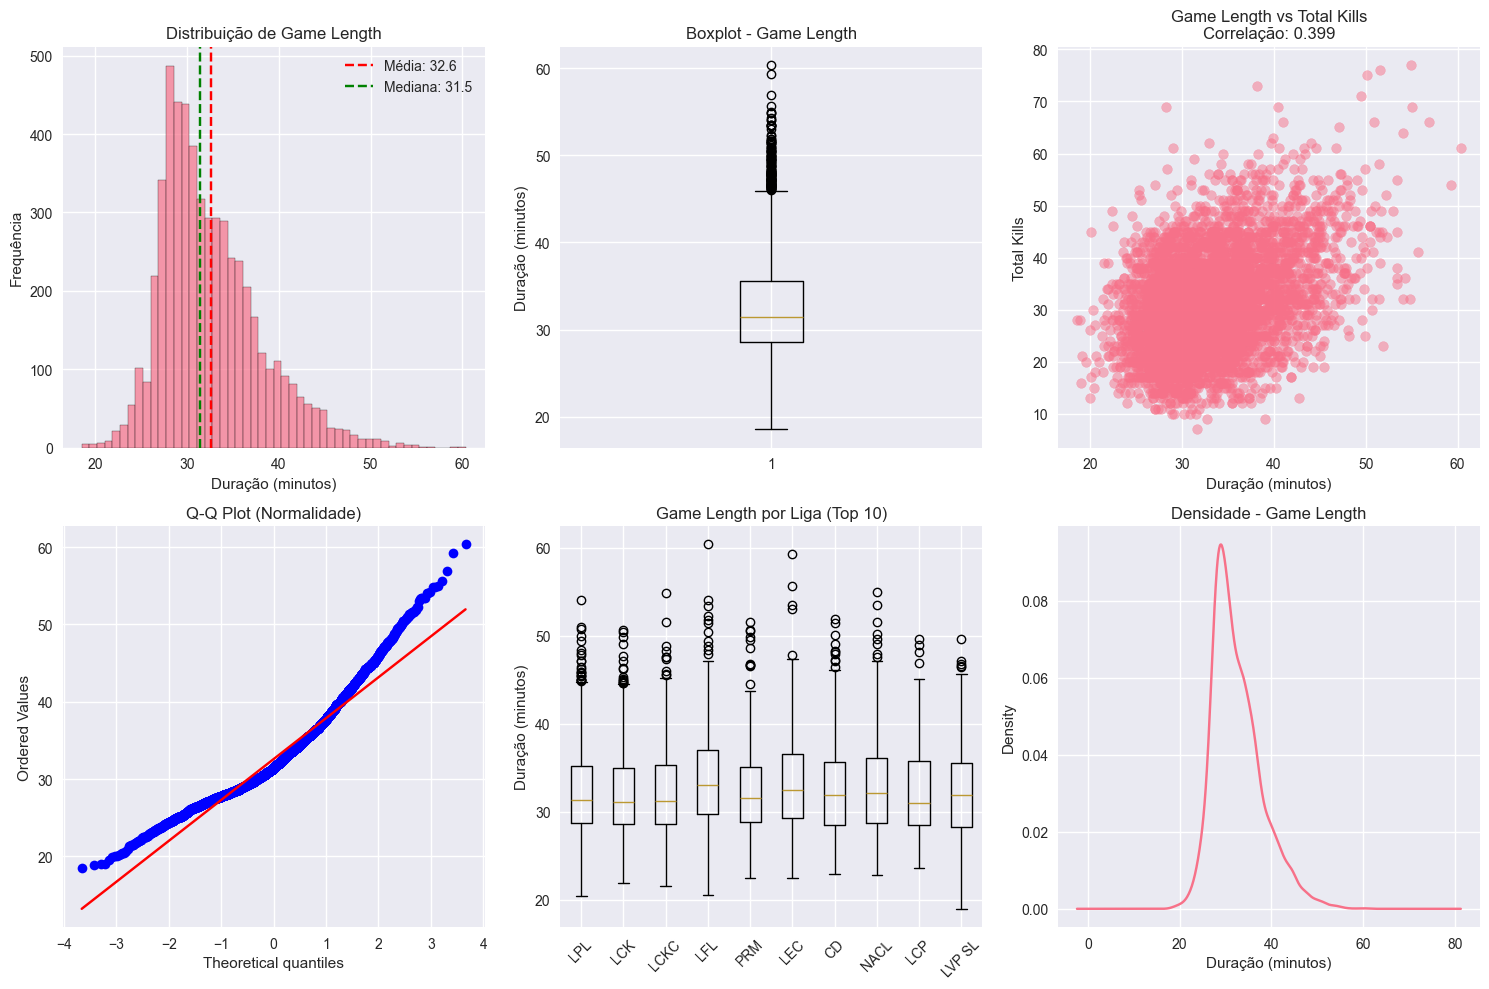


=== TESTE DE NORMALIDADE (Shapiro-Wilk) ===
Estatística: 0.948767
P-valor: 0.000000
Distribuição normal: Não

=== RECOMENDAÇÕES ===
✅ Quantidade razoável de outliers (<5%)
✅ Correlação moderada com total_kills (0.399)
- Game length pode ser feature útil para o modelo


In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Análise básica de game length
print("=== ANÁLISE DE GAME LENGTH ===")
print(f"Shape do dataset: {matches_df.shape}")
print(f"\nEstatísticas básicas:")
print(matches_df["gamelength"].describe())

# Verificar missing values
print(f"\nMissing values em gamelength: {matches_df['gamelength'].isnull().sum()}")

# Identificar outliers usando IQR
Q1 = matches_df["gamelength"].quantile(0.25)
Q3 = matches_df["gamelength"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = matches_df[
    (matches_df["gamelength"] < lower_bound) | (matches_df["gamelength"] > upper_bound)
]
print(f"\n=== OUTLIERS (Método IQR) ===")
print(f"Limite inferior: {lower_bound:.2f} minutos")
print(f"Limite superior: {upper_bound:.2f} minutos")
print(
    f"Outliers encontrados: {len(outliers_iqr)} jogos ({len(outliers_iqr) / len(matches_df) * 100:.2f}%)"
)

# Outliers usando Z-score
z_scores = np.abs(stats.zscore(matches_df["gamelength"].dropna()))
outliers_zscore = matches_df[z_scores > 3]
print(f"\n=== OUTLIERS (Z-score > 3) ===")
print(
    f"Outliers encontrados: {len(outliers_zscore)} jogos ({len(outliers_zscore) / len(matches_df) * 100:.2f}%)"
)

# Mostrar alguns outliers extremos
print(f"\n=== OUTLIERS EXTREMOS ===")
print("5 jogos mais curtos:")
shortest = matches_df.nsmallest(5, "gamelength")[
    ["gamelength", "total_kills", "league"]
]
print(shortest)

print("\n5 jogos mais longos:")
longest = matches_df.nlargest(5, "gamelength")[["gamelength", "total_kills", "league"]]
print(longest)

# Análise por liga
print(f"\n=== DISTRIBUIÇÃO POR LIGA ===")
league_stats = (
    matches_df.groupby("league")["gamelength"]
    .agg(["count", "mean", "std", "min", "max"])
    .round(2)
)
league_stats = league_stats.sort_values("mean", ascending=False)
print(league_stats)

# Correlação com total_kills
correlation = matches_df["gamelength"].corr(matches_df["total_kills"])
print(f"\n=== CORRELAÇÃO ===")
print(f"Correlação gamelength vs total_kills: {correlation:.3f}")

# Visualizações
plt.figure(figsize=(15, 10))

# Histograma
plt.subplot(2, 3, 1)
plt.hist(matches_df["gamelength"], bins=50, alpha=0.7, edgecolor="black")
plt.title("Distribuição de Game Length")
plt.xlabel("Duração (minutos)")
plt.ylabel("Frequência")
plt.axvline(
    matches_df["gamelength"].mean(),
    color="red",
    linestyle="--",
    label=f"Média: {matches_df['gamelength'].mean():.1f}",
)
plt.axvline(
    matches_df["gamelength"].median(),
    color="green",
    linestyle="--",
    label=f"Mediana: {matches_df['gamelength'].median():.1f}",
)
plt.legend()

# Boxplot
plt.subplot(2, 3, 2)
plt.boxplot(matches_df["gamelength"])
plt.title("Boxplot - Game Length")
plt.ylabel("Duração (minutos)")

# Scatter plot: gamelength vs total_kills
plt.subplot(2, 3, 3)
plt.scatter(matches_df["gamelength"], matches_df["total_kills"], alpha=0.5)
plt.title(f"Game Length vs Total Kills\nCorrelação: {correlation:.3f}")
plt.xlabel("Duração (minutos)")
plt.ylabel("Total Kills")

# Q-Q plot para normalidade
plt.subplot(2, 3, 4)
stats.probplot(matches_df["gamelength"], dist="norm", plot=plt)
plt.title("Q-Q Plot (Normalidade)")

# Distribuição por liga (top 10)
plt.subplot(2, 3, 5)
top_leagues = matches_df["league"].value_counts().head(10).index
league_data = [
    matches_df[matches_df["league"] == league]["gamelength"] for league in top_leagues
]
plt.boxplot(league_data, labels=top_leagues)
plt.xticks(rotation=45)
plt.title("Game Length por Liga (Top 10)")
plt.ylabel("Duração (minutos)")

# Densidade
plt.subplot(2, 3, 6)
matches_df["gamelength"].plot(kind="density")
plt.title("Densidade - Game Length")
plt.xlabel("Duração (minutos)")

plt.tight_layout()
plt.show()

# Teste de normalidade
shapiro_stat, shapiro_p = stats.shapiro(
    matches_df["gamelength"].sample(5000)
)  # Sample para performance
print(f"\n=== TESTE DE NORMALIDADE (Shapiro-Wilk) ===")
print(f"Estatística: {shapiro_stat:.6f}")
print(f"P-valor: {shapiro_p:.6f}")
print(f"Distribuição normal: {'Não' if shapiro_p < 0.05 else 'Sim'}")

# Recomendações para outliers
print(f"\n=== RECOMENDAÇÕES ===")
if len(outliers_iqr) > len(matches_df) * 0.05:  # Mais de 5% outliers
    print("⚠️  Muitos outliers detectados (>5%)")
    print(
        "- Considere investigar jogos muito curtos (<15 min) ou muito longos (>45 min)"
    )
    print("- Possíveis remake/surrender early ou jogos técnicos")
else:
    print("✅ Quantidade razoável de outliers (<5%)")

if correlation > 0.3:
    print(f"✅ Correlação moderada com total_kills ({correlation:.3f})")
    print("- Game length pode ser feature útil para o modelo")
else:
    print(f"⚠️  Correlação fraca com total_kills ({correlation:.3f})")

In [154]:
# Remover outliers de gamelength usando método IQR
print("=== REMOVENDO OUTLIERS DE GAMELENGTH ===")

print(f"Dataset original: {matches_df.shape[0]} jogos")

# Calcular limites IQR
Q1 = matches_df["gamelength"].quantile(0.25)
Q3 = matches_df["gamelength"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Limite inferior: {lower_bound:.2f} minutos")
print(f"Limite superior: {upper_bound:.2f} minutos")

# Identificar outliers
outliers_mask = (matches_df["gamelength"] < lower_bound) | (
    matches_df["gamelength"] > upper_bound
)
outliers_count = outliers_mask.sum()

print(
    f"Outliers identificados: {outliers_count} jogos ({outliers_count / len(matches_df) * 100:.2f}%)"
)

# Remover outliers
df_clean = matches_df[~outliers_mask].copy()

print(f"Dataset após remoção: {df_clean.shape[0]} jogos")
print(f"Jogos removidos: {outliers_count}")

# Verificar nova distribuição
print(f"\nNova distribuição de gamelength:")
print(df_clean["gamelength"].describe().round(2))

# Remover coluna gamelength
df_clean = df_clean.drop(["gamelength", "year", "date", "patch", "game"], axis=1)

print(f"\nDataset final após remover coluna gamelength:")
print(f"Shape: {df_clean.shape}")
print(f"Colunas restantes: {list(df_clean.columns)}")

# Atualizar o dataframe principal
matches_df = df_clean.copy()

print(f"\n✅ Outliers removidos e coluna gamelength excluída")
print(f"Dataset final: {matches_df.shape}")

=== REMOVENDO OUTLIERS DE GAMELENGTH ===
Dataset original: 5539 jogos
Limite inferior: 18.20 minutos
Limite superior: 45.99 minutos
Outliers identificados: 125 jogos (2.26%)
Dataset após remoção: 5414 jogos
Jogos removidos: 125

Nova distribuição de gamelength:
count    5414.00
mean       32.20
std         4.84
min        18.55
25%        28.58
50%        31.30
75%        35.27
max        45.92
Name: gamelength, dtype: float64

Dataset final após remover coluna gamelength:
Shape: (5414, 16)
Colunas restantes: ['league', 't1', 't2', 'top_t1', 'jung_t1', 'mid_t1', 'adc_t1', 'sup_t1', 'kills_t1', 'top_t2', 'jung_t2', 'mid_t2', 'adc_t2', 'sup_t2', 'kills_t2', 'total_kills']

✅ Outliers removidos e coluna gamelength excluída
Dataset final: (5414, 16)


In [155]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

ROLES = ["top", "jung", "mid", "adc", "sup"]


def calculate_champion_impacts_simple(df, min_games=15):
    overall_mean = df["total_kills"].mean()
    champion_columns = [f"{role}_{team}" for role in ROLES for team in ["t1", "t2"]]
    champion_impacts = {}
    champion_counts = {}

    for col in champion_columns:
        for champion in df[col].dropna().unique():
            if champion not in champion_counts:
                champion_counts[champion] = 0
                champion_impacts[champion] = []

            champion_games = df[df[col] == champion]["total_kills"]
            champion_impacts[champion].extend(champion_games.tolist())
            champion_counts[champion] += len(champion_games)

    final_impacts = {}
    for champion in champion_impacts:
        if champion_counts[champion] >= min_games:
            mean_kills = np.mean(champion_impacts[champion])
            final_impacts[champion] = mean_kills - overall_mean
        else:
            final_impacts[champion] = 0.0

    return final_impacts, overall_mean, champion_counts


def calculate_champion_impacts_relaxed(df, min_games=20, alpha=0.15):
    overall_mean = df["total_kills"].mean()
    champion_columns = [f"{role}_{team}" for role in ROLES for team in ["t1", "t2"]]
    champion_impacts = {}
    champion_counts = {}

    for col in champion_columns:
        for champion in df[col].dropna().unique():
            if champion not in champion_counts:
                champion_counts[champion] = 0
                champion_impacts[champion] = []

            champion_games = df[df[col] == champion]["total_kills"]
            champion_impacts[champion].extend(champion_games.tolist())
            champion_counts[champion] += len(champion_games)

    final_impacts = {}
    for champion in champion_impacts:
        if champion_counts[champion] >= min_games:
            games = champion_impacts[champion]
            mean_kills = np.mean(games)
            impact = mean_kills - overall_mean

            if len(games) >= 5:
                t_stat, p_val = stats.ttest_1samp(games, overall_mean)
                final_impacts[champion] = impact if p_val < alpha else 0.0
            else:
                final_impacts[champion] = impact if abs(impact) > 1.5 else 0.0
        else:
            final_impacts[champion] = 0.0

    return final_impacts, overall_mean, champion_counts


def create_dataset(df, champion_impacts):
    df_new = df.copy()

    league_means = df_new.groupby("league")["total_kills"].mean()
    df_new["league_mean_kills"] = df_new["league"].map(league_means)
    df_new["target"] = (df_new["total_kills"] > df_new["league_mean_kills"]).astype(int)

    all_teams = pd.concat([df_new["t1"], df_new["t2"]]).unique()
    team_means = {}
    for team in all_teams:
        team_games = df_new[(df_new["t1"] == team) | (df_new["t2"] == team)]
        team_means[team] = team_games["total_kills"].mean()

    df_new["mean_total_kills_t1"] = df_new["t1"].map(team_means)
    df_new["mean_total_kills_t2"] = df_new["t2"].map(team_means)

    for role in ROLES:
        for team in ["t1", "t2"]:
            col = f"{role}_{team}"
            df_new[f"impact_{role}_{team}"] = (
                df_new[col].map(champion_impacts).fillna(0.0)
            )

    columns_final = [
        "total_kills",
        "target",
        "league",
        "league_mean_kills",
        "mean_total_kills_t1",
        "mean_total_kills_t2",
    ] + [f"impact_{role}_{team}" for role in ROLES for team in ["t1", "t2"]]

    return df_new[columns_final]


print("=== CRIANDO DATASET 1: SEM TESTE ===")
impacts_simple, _, counts_simple = calculate_champion_impacts_simple(
    matches_df, min_games=15
)
df_high_champ_impact = create_dataset(matches_df, impacts_simple)

impactos_sig_simple = {k: v for k, v in impacts_simple.items() if v != 0.0}
print(f"Campeões com impacto: {len(impactos_sig_simple)}")
print(f"Dataset shape: {df_high_champ_impact.shape}")
print(f"Balanceamento target: {df_high_champ_impact['target'].value_counts()}")

print("\n=== CRIANDO DATASET 2: TESTE RELAXADO ===")
impacts_relaxed, _, counts_relaxed = calculate_champion_impacts_relaxed(
    matches_df, min_games=20, alpha=0.15
)
df_low_champ_impact = create_dataset(matches_df, impacts_relaxed)

impactos_sig_relaxed = {k: v for k, v in impacts_relaxed.items() if v != 0.0}
print(f"Campeões com impacto: {len(impactos_sig_relaxed)}")
print(f"Dataset shape: {df_low_champ_impact.shape}")
print(f"Balanceamento target: {df_low_champ_impact['target'].value_counts()}")

df_high_champ_impact.to_csv("dataset_ml_simple.csv", index=False)
df_low_champ_impact.to_csv("dataset_ml_relaxed.csv", index=False)

print(f"\nDatasets salvos:")
print(f"- dataset_ml_simple.csv ({len(impactos_sig_simple)} campeões)")
print(f"- dataset_ml_relaxed.csv ({len(impactos_sig_relaxed)} campeões)")

=== CRIANDO DATASET 1: SEM TESTE ===
Campeões com impacto: 137
Dataset shape: (5414, 16)
Balanceamento target: target
0    2848
1    2566
Name: count, dtype: int64

=== CRIANDO DATASET 2: TESTE RELAXADO ===
Campeões com impacto: 65
Dataset shape: (5414, 16)
Balanceamento target: target
0    2848
1    2566
Name: count, dtype: int64

Datasets salvos:
- dataset_ml_simple.csv (137 campeões)
- dataset_ml_relaxed.csv (65 campeões)


# Utilizando low impact champ

✅ Variável target UNDER_KILL criada:
   - Total de partidas: 5414
   - Partidas UNDER_KILL (abaixo da média): 2836 (52.4%)
   - Partidas OVER_KILL (acima da média): 2578 (47.6%)


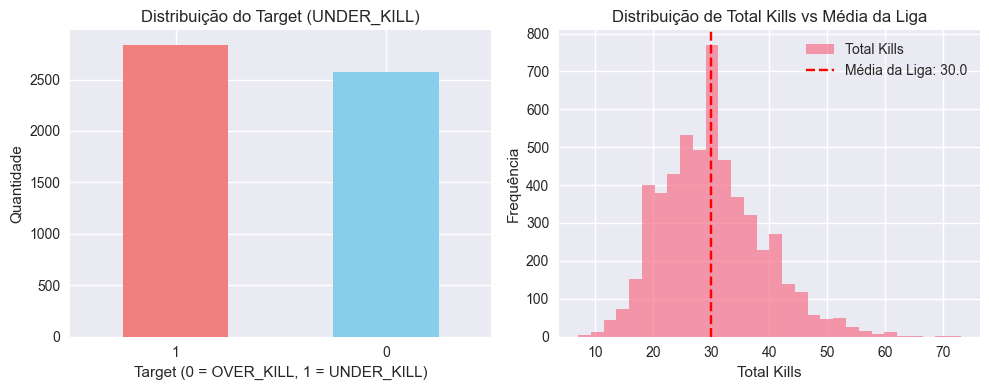

In [156]:
# === CRIAÇÃO DA VARIÁVEL TARGET (UNDER_KILL) ===

if not df_low_champ_impact.empty:
    # Criar target binário para UNDER_KILL
    df_low_champ_impact["target"] = (
        df_low_champ_impact["total_kills"] < df_low_champ_impact["league_mean_kills"]
    ).astype(int)

    print("✅ Variável target UNDER_KILL criada:")
    print(f"   - Total de partidas: {len(df_low_champ_impact)}")
    print(
        f"   - Partidas UNDER_KILL (abaixo da média): {df_low_champ_impact['target'].sum()} ({df_low_champ_impact['target'].mean():.1%})"
    )
    print(
        f"   - Partidas OVER_KILL (acima da média): {len(df_low_champ_impact) - df_low_champ_impact['target'].sum()} ({(1 - df_low_champ_impact['target'].mean()):.1%})"
    )

    # Distribuição do target
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    df_low_champ_impact["target"].value_counts().plot(
        kind="bar", color=["lightcoral", "skyblue"]
    )
    plt.title("Distribuição do Target (UNDER_KILL)")
    plt.xlabel("Target (0 = OVER_KILL, 1 = UNDER_KILL)")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    df_low_champ_impact["total_kills"].hist(bins=30, alpha=0.7, label="Total Kills")
    plt.axvline(
        df_low_champ_impact["league_mean_kills"].mean(),
        color="red",
        linestyle="--",
        label=f"Média da Liga: {df_low_champ_impact['league_mean_kills'].mean():.1f}",
    )
    plt.title("Distribuição de Total Kills vs Média da Liga")
    plt.xlabel("Total Kills")
    plt.ylabel("Frequência")
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("❌ Dataset vazio - não foi possível criar a variável target")

In [157]:
# === ANÁLISE DAS FEATURES ===

if not df_low_champ_impact.empty:
    # Identificar colunas a serem excluídas
    excluded_columns = ["total_kills", "target"]
    feature_columns = [
        col for col in df_low_champ_impact.columns if col not in excluded_columns
    ]

    print(f"🎯 Features disponíveis: {len(feature_columns)}")
    print("📋 Lista de features:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")

    # Estatísticas básicas das features
    if feature_columns:
        print(f"\n📊 Estatísticas das features:")
        features_stats = df_low_champ_impact[feature_columns].describe()
        display(features_stats.head(8))

        # Verificar valores missing
        missing_values = df_low_champ_impact[feature_columns].isnull().sum()
        if missing_values.any():
            print("\n⚠️  Valores missing encontrados:")
            for col, missing_count in missing_values[missing_values > 0].items():
                print(
                    f"   - {col}: {missing_count} valores missing ({missing_count / len(df_low_champ_impact):.1%})"
                )
        else:
            print("✅ Nenhum valor missing nas features")

else:
    print("❌ Dataset vazio - não foi possível analisar as features")

🎯 Features disponíveis: 14
📋 Lista de features:
    1. league
    2. league_mean_kills
    3. mean_total_kills_t1
    4. mean_total_kills_t2
    5. impact_top_t1
    6. impact_top_t2
    7. impact_jung_t1
    8. impact_jung_t2
    9. impact_mid_t1
   10. impact_mid_t2
   11. impact_adc_t1
   12. impact_adc_t2
   13. impact_sup_t1
   14. impact_sup_t2

📊 Estatísticas das features:


,league_mean_kills,mean_total_kills_t1,mean_total_kills_t2,impact_top_t1,impact_top_t2,impact_jung_t1,impact_jung_t2,impact_mid_t1,impact_mid_t2,impact_adc_t1,impact_adc_t2,impact_sup_t1,impact_sup_t2
count,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000
mean,29.988918,29.956188,30.021647,-0.011465,0.021594,0.012293,0.004417,0.012372,0.057366,-0.068203,-0.048298,-0.014591,-0.022570
std,1.910771,2.676128,2.672150,0.811166,0.931262,0.874793,0.883624,0.604018,0.611962,0.692643,0.695313,1.189980,1.158241
min,26.645833,24.461538,24.461538,-3.118788,-3.118788,-3.118788,-3.118788,-2.688918,-2.688918,-2.391092,-2.391092,-4.015233,-4.015233
25%,28.729323,28.188235,28.212121,-0.456796,-0.456796,-0.578437,-0.578437,-0.387355,0.000000,-0.377673,-0.377673,-0.869089,-0.869089
50%,29.813776,29.845361,29.928571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,31.324503,31.346154,0.601701,0.601701,0.327538,0.327538,0.000000,0.000000,0.461004,0.442946,0.524224,0.524224
max,32.956731,61.000000,61.000000,5.796797,5.796797,3.399971,3.399971,4.974045,4.974045,5.796797,5.796797,3.753350,3.753350


✅ Nenhum valor missing nas features


📈 Matriz de Correlação com o Target:
🔍 Features com correlação significativa com o target (|r| > 0.05):
   - impact_mid_t1: -0.034
   - impact_adc_t2: -0.052
   - impact_mid_t2: -0.066
   - impact_top_t1: -0.069
   - impact_adc_t1: -0.073
   - impact_top_t2: -0.074
   - impact_jung_t2: -0.091
   - impact_jung_t1: -0.094
   - impact_sup_t2: -0.099
   - impact_sup_t1: -0.121
   - mean_total_kills_t1: -0.126
   - mean_total_kills_t2: -0.127


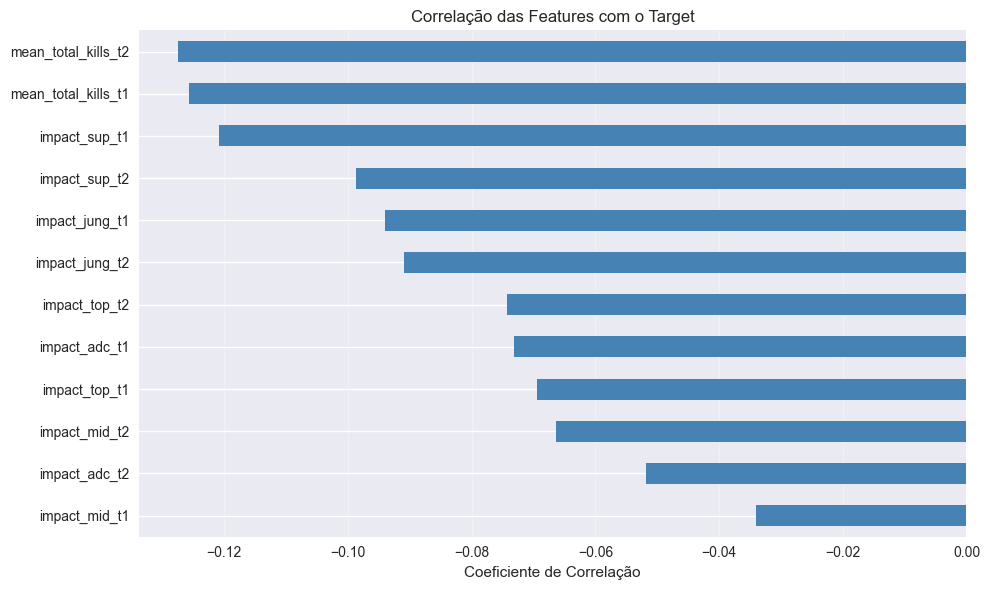

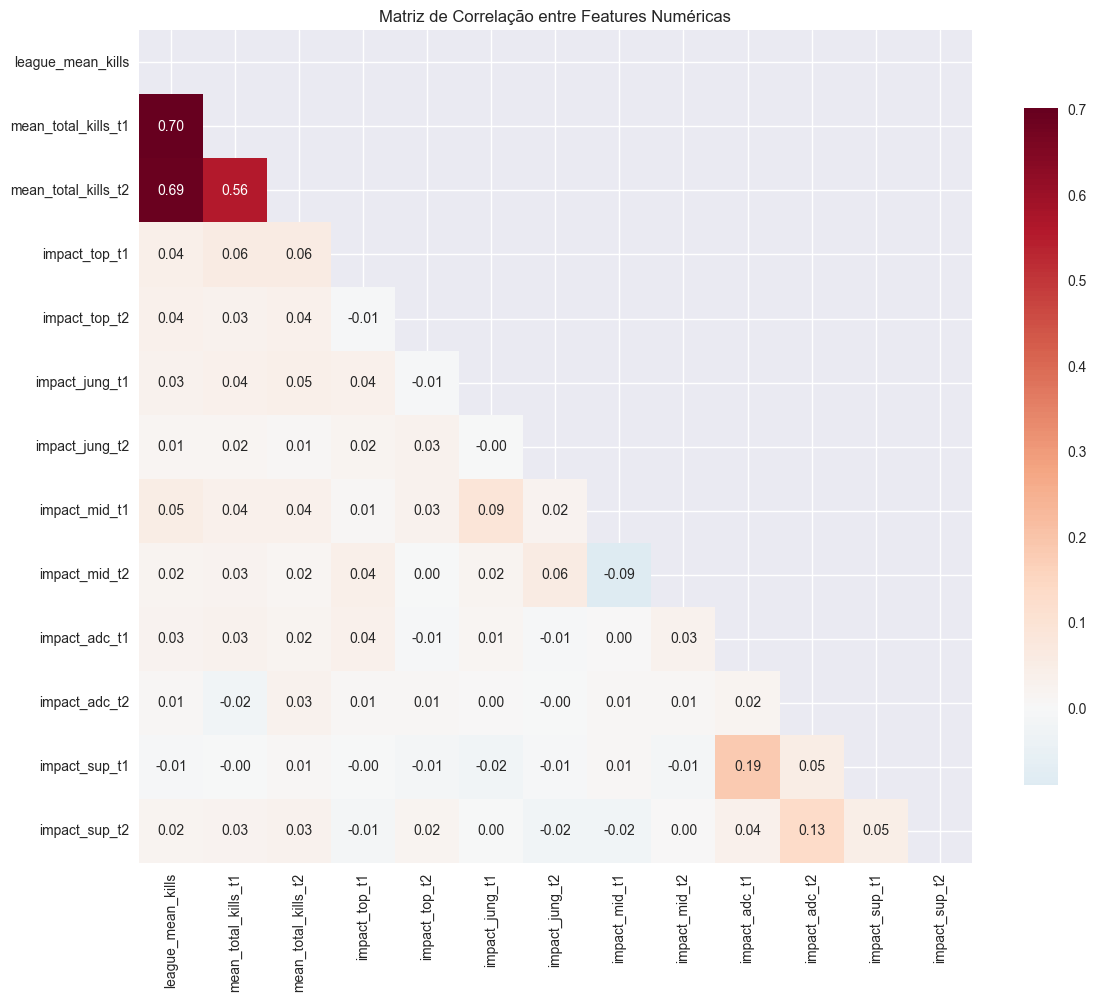

In [158]:
# === ANÁLISE DE CORRELAÇÕES ===

if not df_low_champ_impact.empty:
    # Calcular matriz de correlação apenas com features numéricas
    numeric_features = df_low_champ_impact[feature_columns].select_dtypes(
        include=[np.number]
    )

    print("📈 Matriz de Correlação com o Target:")

    # Correlações com o target
    target_correlations = (
        df_low_champ_impact[numeric_features.columns.tolist() + ["target"]]
        .corr()["target"]
        .sort_values(ascending=False)
    )

    # Filtrar apenas correlações significativas (abs > 0.05)
    significant_corrs = target_correlations[abs(target_correlations) > 0.03]
    significant_corrs = significant_corrs.drop("target", errors="ignore")

    if len(significant_corrs) > 0:
        print("🔍 Features com correlação significativa com o target (|r| > 0.05):")
        for feature, corr in significant_corrs.items():
            print(f"   - {feature}: {corr:.3f}")

        # Plot das correlações mais importantes
        plt.figure(figsize=(10, 6))
        significant_corrs.plot(kind="barh", color="steelblue")
        plt.title("Correlação das Features com o Target")
        plt.xlabel("Coeficiente de Correlação")
        plt.grid(axis="x", alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  Nenhuma feature com correlação significativa (|r| > 0.04) encontrada")

    # Matriz de correlação completa
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_features.corr()

    # Máscara para mostrar apenas metade da matriz
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        cmap="RdBu_r",
        center=0,
        square=True,
        fmt=".2f",
        cbar_kws={"shrink": 0.8},
    )
    plt.title("Matriz de Correlação entre Features Numéricas")
    plt.tight_layout()
    plt.show()

else:
    print("❌ Dataset vazio - não foi possível calcular correlações")

📈 ANÁLISE DETALHADA DE CORRELAÇÕES COM UNDER_KILL

🎯 CORRELAÇÕES POR TIPO DE FEATURE:

1. IMPACT POR POSIÇÃO (Team 1 vs Team 2):
     TOP: T1= -0.069 ( MUITO FRACA) | T2= -0.074 ( MUITO FRACA)
    JUNG: T1= -0.094 ( MUITO FRACA) | T2= -0.091 ( MUITO FRACA)
     MID: T1= -0.034 ( MUITO FRACA) | T2= -0.066 ( MUITO FRACA)
     ADC: T1= -0.073 ( MUITO FRACA) | T2= -0.052 ( MUITO FRACA)
     SUP: T1= -0.121 (       FRACA) | T2= -0.099 ( MUITO FRACA)

2. MÉDIAS DE KILLS POR TIME:
   league_mean_kills: -0.012 (MUITO FRACA)
   mean_total_kills_t1: -0.126 (FRACA)
   mean_total_kills_t2: -0.127 (FRACA)

📊 ESTATÍSTICAS DETALHADAS:
   - Total de features analisadas: 13
   - Features com correlação |r| > 0.1: 3
   - Features com correlação |r| > 0.05: 11

3. CORRELAÇÃO MÉDIA POR POSIÇÃO:
     TOP: Média=-0.072 | Min=-0.074 | Max=-0.069
    JUNG: Média=-0.093 | Min=-0.094 | Max=-0.091
     MID: Média=-0.050 | Min=-0.066 | Max=-0.034
     ADC: Média=-0.063 | Min=-0.073 | Max=-0.052
     SUP: Média=-0

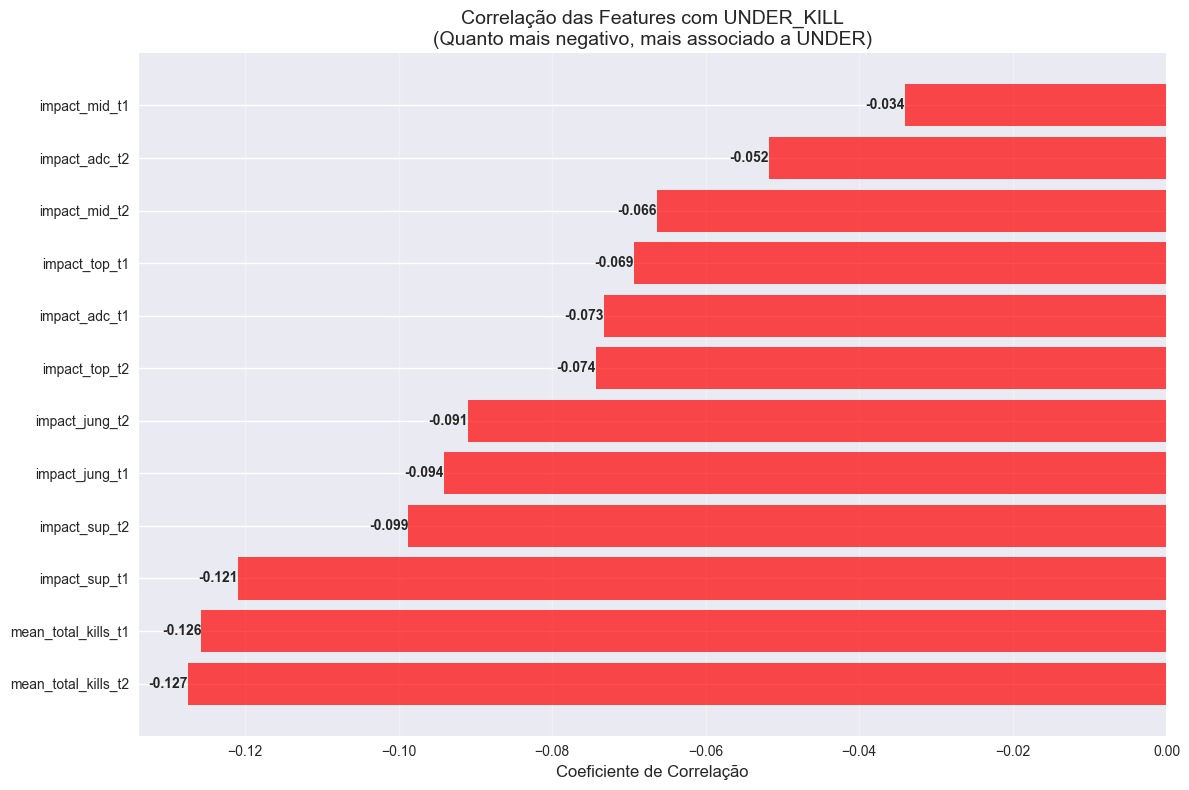


💡 INSIGHTS E INTERPRETAÇÕES:
   • Valores NEGATIVOS: Associados com UNDER_KILL (menos kills)
   • Valores POSITIVOS: Associados com OVER_KILL (mais kills)

   📉 TOP 3 features para UNDER_KILL:
      - mean_total_kills_t2: -0.127 (maior impacto negativo)
      - mean_total_kills_t1: -0.126 (maior impacto negativo)
      - impact_sup_t1: -0.121 (maior impacto negativo)

   📈 TOP 3 features para OVER_KILL:
      - impact_mid_t2: -0.066 (maior impacto positivo)
      - impact_adc_t2: -0.052 (maior impacto positivo)
      - impact_mid_t1: -0.034 (maior impacto positivo)


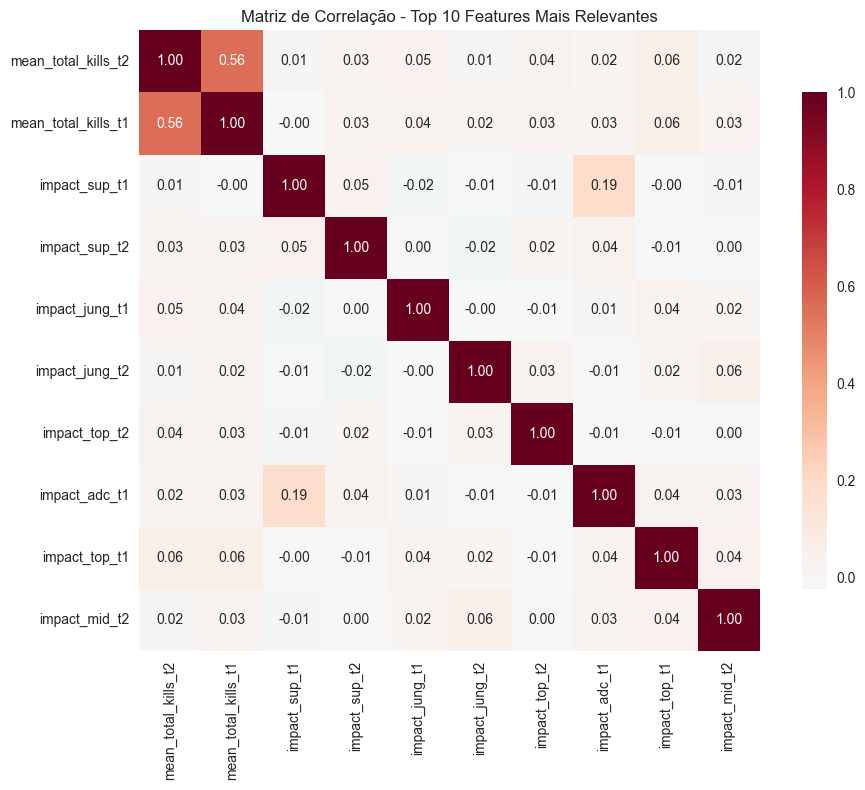

In [159]:
# === ANÁLISE DE CORRELAÇÕES APROFUNDADA ===

if not df_low_champ_impact.empty:
    # Calcular matriz de correlação apenas com features numéricas
    numeric_features = df_low_champ_impact[feature_columns].select_dtypes(
        include=[np.number]
    )

    print("📈 ANÁLISE DETALHADA DE CORRELAÇÕES COM UNDER_KILL")
    print("=" * 60)

    # Correlações com o target
    target_correlations = (
        df_low_champ_impact[numeric_features.columns.tolist() + ["target"]]
        .corr()["target"]
        .sort_values(ascending=False)
    )

    # Separar correlações por tipo de feature
    impact_features = [f for f in target_correlations.index if "impact_" in f]
    mean_features = [f for f in target_correlations.index if "mean_" in f]
    other_features = [
        f
        for f in target_correlations.index
        if f not in impact_features + mean_features + ["target"]
    ]

    print("\n🎯 CORRELAÇÕES POR TIPO DE FEATURE:")

    # Análise das correlações de impacto por posição
    print("\n1. IMPACT POR POSIÇÃO (Team 1 vs Team 2):")
    positions = ["top", "jung", "mid", "adc", "sup"]

    for pos in positions:
        t1_feature = f"impact_{pos}_t1"
        t2_feature = f"impact_{pos}_t2"

        t1_corr = target_correlations.get(t1_feature, 0)
        t2_corr = target_correlations.get(t2_feature, 0)

        # Interpretação da força da correlação
        def get_correlation_strength(corr):
            abs_corr = abs(corr)
            if abs_corr < 0.1:
                return "MUITO FRACA"
            elif abs_corr < 0.3:
                return "FRACA"
            elif abs_corr < 0.5:
                return "MODERADA"
            else:
                return "FORTE"

        print(
            f"   {pos.upper():>5}: T1={t1_corr:7.3f} ({get_correlation_strength(t1_corr):>12}) | T2={t2_corr:7.3f} ({get_correlation_strength(t2_corr):>12})"
        )

    print("\n2. MÉDIAS DE KILLS POR TIME:")
    for feature in mean_features:
        corr = target_correlations.get(feature, 0)
        print(f"   {feature}: {corr:.3f} ({get_correlation_strength(corr)})")

    # Análise estatística mais detalhada
    print("\n📊 ESTATÍSTICAS DETALHADAS:")
    print(f"   - Total de features analisadas: {len(target_correlations) - 1}")
    print(
        f"   - Features com correlação |r| > 0.1: {sum(abs(target_correlations.drop('target', errors='ignore')) > 0.1)}"
    )
    print(
        f"   - Features com correlação |r| > 0.05: {sum(abs(target_correlations.drop('target', errors='ignore')) > 0.05)}"
    )

    # Correlação média por posição
    print("\n3. CORRELAÇÃO MÉDIA POR POSIÇÃO:")
    for pos in positions:
        pos_features = [f for f in target_correlations.index if f"impact_{pos}_" in f]
        if pos_features:
            avg_corr = target_correlations[pos_features].mean()
            max_corr = target_correlations[pos_features].max()
            min_corr = target_correlations[pos_features].min()
            print(
                f"   {pos.upper():>5}: Média={avg_corr:.3f} | Min={min_corr:.3f} | Max={max_corr:.3f}"
            )

    # Filtrar apenas correlações significativas (abs > 0.03)
    significant_corrs = target_correlations[abs(target_correlations) > 0.03]
    significant_corrs = significant_corrs.drop("target", errors="ignore")

    if len(significant_corrs) > 0:
        print(f"\n🔍 FEATURES MAIS RELEVANTES (|r| > 0.03):")
        for feature, corr in significant_corrs.items():
            direction = "NEGATIVA" if corr < 0 else "POSITIVA"
            strength = get_correlation_strength(corr)
            print(f"   - {feature:25}: {corr:7.3f} ({direction}, {strength})")

        # Plot das correlações mais importantes
        plt.figure(figsize=(12, 8))

        # Ordenar por magnitude da correlação
        significant_corrs_sorted = significant_corrs.reindex(
            significant_corrs.abs().sort_values(ascending=False).index
        )

        colors = ["red" if x < 0 else "blue" for x in significant_corrs_sorted]
        bars = plt.barh(
            range(len(significant_corrs_sorted)),
            significant_corrs_sorted.values,
            color=colors,
            alpha=0.7,
        )

        plt.title(
            "Correlação das Features com UNDER_KILL\n(Quanto mais negativo, mais associado a UNDER)",
            fontsize=14,
        )
        plt.xlabel("Coeficiente de Correlação", fontsize=12)
        plt.yticks(range(len(significant_corrs_sorted)), significant_corrs_sorted.index)
        plt.grid(axis="x", alpha=0.3)

        # Adicionar valores nas barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f"{width:.3f}",
                ha="left" if width > 0 else "right",
                va="center",
                fontweight="bold",
            )

        plt.tight_layout()
        plt.show()

        # Análise de insights
        print("\n💡 INSIGHTS E INTERPRETAÇÕES:")
        print("   • Valores NEGATIVOS: Associados com UNDER_KILL (menos kills)")
        print("   • Valores POSITIVOS: Associados com OVER_KILL (mais kills)")
        print("\n   📉 TOP 3 features para UNDER_KILL:")
        under_features = significant_corrs_sorted.head(3)
        for feature, corr in under_features.items():
            print(f"      - {feature}: {corr:.3f} (maior impacto negativo)")

        print("\n   📈 TOP 3 features para OVER_KILL:")
        over_features = significant_corrs_sorted.tail(3)
        for feature, corr in over_features.items():
            print(f"      - {feature}: {corr:.3f} (maior impacto positivo)")

    else:
        print("⚠️  Nenhuma feature com correlação significativa (|r| > 0.03) encontrada")

    # Matriz de correlação focada nas features mais relevantes
    if len(significant_corrs) > 1:
        top_features = significant_corrs_sorted.index[:10]  # Top 10 features
        correlation_matrix = df_low_champ_impact[top_features.tolist()].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            correlation_matrix,
            annot=True,
            cmap="RdBu_r",
            center=0,
            square=True,
            fmt=".2f",
            cbar_kws={"shrink": 0.8},
        )
        plt.title("Matriz de Correlação - Top 10 Features Mais Relevantes")
        plt.tight_layout()
        plt.show()

else:
    print("❌ Dataset vazio - não foi possível calcular correlações")

In [160]:
# === LIMPEZA DAS FEATURES ===

if not df_low_champ_impact.empty:
    # Remover colunas que não devem ser usadas como features
    columns_to_remove = ["total_kills", "league", "league_mean_kills"]

    print("🧹 LIMPEZA DAS FEATURES:")
    print(f"   - Colunas removidas: {columns_to_remove}")
    print(f"   - Shape original: {df_low_champ_impact.shape}")

    # Criar lista de features limpas (apenas colunas numéricas relevantes)
    feature_columns_clean = [
        col for col in feature_columns if col not in columns_to_remove
    ]

    # Verificar se todas as features limpas existem no DataFrame
    missing_features = [
        col for col in feature_columns_clean if col not in df_low_champ_impact.columns
    ]
    if missing_features:
        print(f"⚠️  Features faltantes: {missing_features}")
        feature_columns_clean = [
            col for col in feature_columns_clean if col in df_low_champ_impact.columns
        ]

    print(f"   - Features disponíveis: {len(feature_columns_clean)}")
    print(f"   - Features após limpeza: {feature_columns_clean}")

    # Verificar valores nulos nas features selecionadas
    null_check = df_low_champ_impact[feature_columns_clean].isnull().sum()
    if null_check.any():
        print("\n⚠️  VALORES NULOS ENCONTRADOS:")
        for col, null_count in null_check[null_check > 0].items():
            print(
                f"   - {col}: {null_count} nulos ({null_count / len(df_low_champ_impact):.1%})"
            )

        # Remover linhas com valores nulos se necessário
        before_size = len(df_low_champ_impact)
        df_clean = df_low_champ_impact.dropna(subset=feature_columns_clean)
        after_size = len(df_clean)

        if after_size < before_size:
            print(f"   - Removidas {before_size - after_size} linhas com valores nulos")
            print(f"   - Novo tamanho do dataset: {after_size}")
        else:
            df_clean = df_low_champ_impact.copy()
    else:
        df_clean = df_low_champ_impact.copy()
        print("   - ✅ Nenhum valor nulo encontrado")

🧹 LIMPEZA DAS FEATURES:
   - Colunas removidas: ['total_kills', 'league', 'league_mean_kills']
   - Shape original: (5414, 16)
   - Features disponíveis: 12
   - Features após limpeza: ['mean_total_kills_t1', 'mean_total_kills_t2', 'impact_top_t1', 'impact_top_t2', 'impact_jung_t1', 'impact_jung_t2', 'impact_mid_t1', 'impact_mid_t2', 'impact_adc_t1', 'impact_adc_t2', 'impact_sup_t1', 'impact_sup_t2']
   - ✅ Nenhum valor nulo encontrado



✅ DIVISÃO TREINO-TESTE REALIZADA COM TODAS AS FEATURES LIMPAS:
   - Shape X_train: (4331, 12)
   - Shape X_test:  (1083, 12)
   - Shape y_train: (4331,)
   - Proporção UNDER_KILL no treino: 52.4%
   - Proporção UNDER_KILL no teste:  52.4%


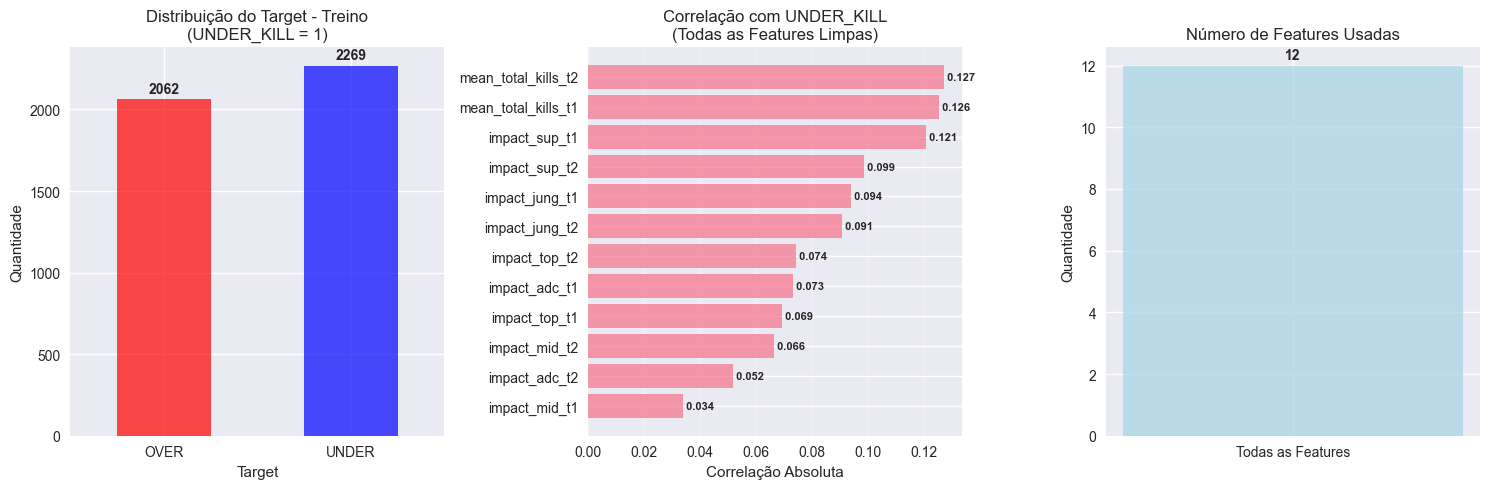


📊 RESUMO FINAL DA LIMPEZA:
   ✅ Colunas removidas: ['total_kills', 'league', 'league_mean_kills']
   ✅ Features disponíveis (todas): 12
   ✅ Tamanho do dataset limpo: 5414 linhas
   ✅ Proporção UNDER_KILL (geral): 52.4%

📋 AMOSTRA DO DATASET LIMPO:
    target  mean_total_kills_t1  mean_total_kills_t2  impact_top_t1  \
4        1            28.212121            28.375000      -1.360313   
5        1            28.375000            28.212121       0.848657   
7        0            28.375000            28.212121       0.000000   
11       1            29.742268            31.809091      -1.360313   
12       1            31.809091            29.742268       0.000000   

    impact_top_t2  impact_jung_t1  
4       -0.640312        0.000000  
5       -0.456796       -0.969310  
7       -0.503752        0.000000  
11      -0.456796       -0.969310  
12      -0.640312       -0.542934  


In [161]:
# === DIVISÃO TREINO-TESTE COM TODAS AS FEATURES LIMPAS ===
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

if not df_clean.empty:
    # 1) Definir matriz X (todas as features limpas) e vetor y
    X = df_clean[feature_columns_clean]
    y = df_clean["target"].values

    # 2) Dividir em treino e teste (80% / 20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

    print("\n✅ DIVISÃO TREINO-TESTE REALIZADA COM TODAS AS FEATURES LIMPAS:")
    print(f"   - Shape X_train: {X_train.shape}")
    print(f"   - Shape X_test:  {X_test.shape}")
    print(f"   - Shape y_train: {y_train.shape}")
    print(f"   - Proporção UNDER_KILL no treino: {y_train.mean():.1%}")
    print(f"   - Proporção UNDER_KILL no teste:  {y_test.mean():.1%}")

    # 3) Visualizações rápidas
    plt.figure(figsize=(15, 5))

    # 3.1) Distribuição do target no treino
    plt.subplot(1, 3, 1)
    vc = pd.Series(y_train).value_counts().sort_index()
    vc.plot(kind="bar", alpha=0.7, color=["red", "blue"])
    plt.title("Distribuição do Target - Treino\n(UNDER_KILL = 1)")
    plt.xlabel("Target")
    plt.ylabel("Quantidade")
    plt.xticks([0, 1], ["OVER", "UNDER"], rotation=0)
    for i, count in enumerate(vc):
        plt.text(
            i,
            count + max(1, int(0.01 * vc.max())),
            str(int(count)),
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # 3.2) Correlação absoluta das features com o target (no dataset completo)
    plt.subplot(1, 3, 2)
    corr_with_target = (
        df_clean[feature_columns_clean].corrwith(df_clean["target"]).abs()
    )
    corr_sorted = corr_with_target.sort_values(ascending=True)

    bars = plt.barh(range(len(corr_sorted)), corr_sorted.values, alpha=0.7)
    plt.yticks(range(len(corr_sorted)), corr_sorted.index)
    plt.title("Correlação com UNDER_KILL\n(Todas as Features Limpas)")
    plt.xlabel("Correlação Absoluta")
    plt.grid(axis="x", alpha=0.3)
    for i, (col, corr) in enumerate(corr_sorted.items()):
        plt.text(corr, i, f" {corr:.3f}", va="center", fontsize=8, fontweight="bold")

    # 3.3) Contagem total de features usadas
    plt.subplot(1, 3, 3)
    plt.bar(["Todas as Features"], [X_train.shape[1]], color="lightblue", alpha=0.8)
    plt.title("Número de Features Usadas")
    plt.ylabel("Quantidade")
    plt.text(
        0,
        X_train.shape[1] + 0.1,
        str(X_train.shape[1]),
        ha="center",
        va="bottom",
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()

    # 4) Empacotar saída útil para etapas seguintes do pipeline
    train_test_data = {
        "all_features": (X_train, X_test, y_train, y_test),
        "feature_names": list(X.columns),
        "df_clean": df_clean,
    }

    print("\n📊 RESUMO FINAL DA LIMPEZA:")
    try:
        print(f"   ✅ Colunas removidas: {columns_to_remove}")
    except NameError:
        print("   ℹ️  'columns_to_remove' não definida neste escopo.")
    print(f"   ✅ Features disponíveis (todas): {len(feature_columns_clean)}")
    print(f"   ✅ Tamanho do dataset limpo: {len(df_clean)} linhas")
    print(f"   ✅ Proporção UNDER_KILL (geral): {df_clean['target'].mean():.1%}")

    # 5) Amostra do dataset limpo
    print(f"\n📋 AMOSTRA DO DATASET LIMPO:")
    preview_cols = ["target"] + (
        feature_columns_clean[:5]
        if len(feature_columns_clean) >= 5
        else feature_columns_clean
    )
    print(df_clean[preview_cols].head())

else:
    print("❌ Dataset vazio após limpeza")

In [162]:
# === FUNÇÕES PARA CÁLCULO DE MÉTRICAS DE APOSTAS ===

# Definir ODDS padrão se não estiver definido
try:
    ODDS
except NameError:
    ODDS = 1.83  # Odds típicas para mercado UNDER/OVER
    print(f"⚠️  Variável ODDS não definida. Usando valor padrão: {ODDS}")


def calculate_betting_metrics(true_labels, predicted_probs, threshold, odds=ODDS):
    """
    Calcula métricas de performance para apostas esportivas.

    Args:
        true_labels: Array com os rótulos verdadeiros (0 ou 1)
        predicted_probs: Array com as probabilidades previstas
        threshold: Limiar para decisão de aposta (0 a 1)
        odds: Odds oferecidas pela casa de apostas

    Returns:
        Dicionário com métricas de apostas
    """
    # Validação dos inputs
    if len(true_labels) != len(predicted_probs):
        raise ValueError("true_labels e predicted_probs devem ter o mesmo tamanho")

    if not (0 <= threshold <= 1):
        raise ValueError("threshold deve estar entre 0 e 1")

    if odds < 1.0:
        raise ValueError("odds devem ser maiores ou iguais a 1.0")

    # Decisões de aposta baseadas no threshold
    bet_decisions = (predicted_probs >= threshold).astype(int)
    total_bets = bet_decisions.sum()

    if total_bets == 0:
        return {
            "total_bets": 0,
            "successful_bets": 0,
            "win_rate": 0.0,
            "net_profit": 0.0,
            "return_on_investment": 0.0,
            "betting_efficiency": 0.0,  # Nova métrica
        }

    # Calcular acertos e erros
    successful_bets = ((bet_decisions == 1) & (true_labels == 1)).sum()
    failed_bets = total_bets - successful_bets

    # Calcular lucro e ROI
    net_profit = successful_bets * (odds - 1) - failed_bets
    return_on_investment = (net_profit / total_bets) * 100

    # Nova métrica: eficiência de apostas (comparado com apostas aleatórias)
    base_win_rate = true_labels.mean()  # Proporção de UNDER no mercado
    expected_profit_random = base_win_rate * (odds - 1) - (1 - base_win_rate)
    betting_efficiency = (
        net_profit / (total_bets * expected_profit_random)
        if expected_profit_random != 0
        else 0
    )

    return {
        "total_bets": int(total_bets),
        "successful_bets": int(successful_bets),
        "win_rate": float(successful_bets / total_bets),
        "net_profit": float(net_profit),
        "return_on_investment": float(return_on_investment),
        "betting_efficiency": float(
            betting_efficiency
        ),  # Quanto melhor que apostas aleatórias
        "odds_used": float(odds),
        "threshold_used": float(threshold),
    }


def evaluate_probabilistic_metrics(true_labels, predicted_probs):
    """
    Avalia métricas probabilísticas padrão.
    """
    # Validação para evitar erros com arrays vazios
    if len(true_labels) == 0 or len(predicted_probs) == 0:
        return {
            "auc_roc": 0.0,
            "brier_score": 1.0,  # Pior caso possível
            "log_loss": float("inf"),
        }

    try:
        auc_roc = roc_auc_score(true_labels, predicted_probs)
    except:
        auc_roc = 0.5  # Valor neutro em caso de erro

    try:
        brier_score = brier_score_loss(true_labels, predicted_probs)
    except:
        brier_score = 1.0

    try:
        log_loss_val = log_loss(true_labels, predicted_probs)
    except:
        log_loss_val = float("inf")

    return {
        "auc_roc": float(auc_roc),
        "brier_score": float(brier_score),
        "log_loss": float(log_loss_val),
        "avg_probability": float(predicted_probs.mean()),
        "true_positive_rate": float(true_labels.mean()),
    }


def find_optimal_threshold(true_labels, predicted_probs, odds=ODDS, min_bets=10):
    """
    Encontra o threshold ótimo para maximizar o ROI.
    """
    thresholds = np.arange(0.1, 1.0, 0.05)
    best_roi = -float("inf")
    best_threshold = 0.5
    best_metrics = None

    for threshold in thresholds:
        metrics = calculate_betting_metrics(
            true_labels, predicted_probs, threshold, odds
        )

        # Só considerar thresholds com número mínimo de apostas
        if (
            metrics["total_bets"] >= min_bets
            and metrics["return_on_investment"] > best_roi
        ):
            best_roi = metrics["return_on_investment"]
            best_threshold = threshold
            best_metrics = metrics

    return best_threshold, best_metrics


print("✅ Funções para métricas de apostas definidas e validadas")

✅ Funções para métricas de apostas definidas e validadas


🎯 ANÁLISE COMPLETA DE MODELOS E THRESHOLDS

🔧 TREINANDO LogisticRegression...
   ✅ LogisticRegression - AUC: 0.651
   💰 Max Profit: thresh=0.50, profit=346.6
   📈 Max ROI:    thresh=0.85, roi=83.0%
   ⚖️  Balanced:  thresh=0.50, profit=346.6

🔧 TREINANDO RandomForest...
   ✅ RandomForest - AUC: 0.630
   💰 Max Profit: thresh=0.55, profit=295.2
   📈 Max ROI:    thresh=0.85, roi=83.0%
   ⚖️  Balanced:  thresh=0.55, profit=295.2

🔧 TREINANDO XGBoost...
   ✅ XGBoost - AUC: 0.613
   💰 Max Profit: thresh=0.60, profit=254.3
   📈 Max ROI:    thresh=0.90, roi=35.3%
   ⚖️  Balanced:  thresh=0.60, profit=254.3

🔧 TREINANDO GradientBoosting...
   ✅ GradientBoosting - AUC: 0.622
   💰 Max Profit: thresh=0.50, profit=273.3
   📈 Max ROI:    thresh=0.95, roi=83.0%
   ⚖️  Balanced:  thresh=0.50, profit=273.3

📊 ANÁLISE DETALHADA POR MODELO E THRESHOLD


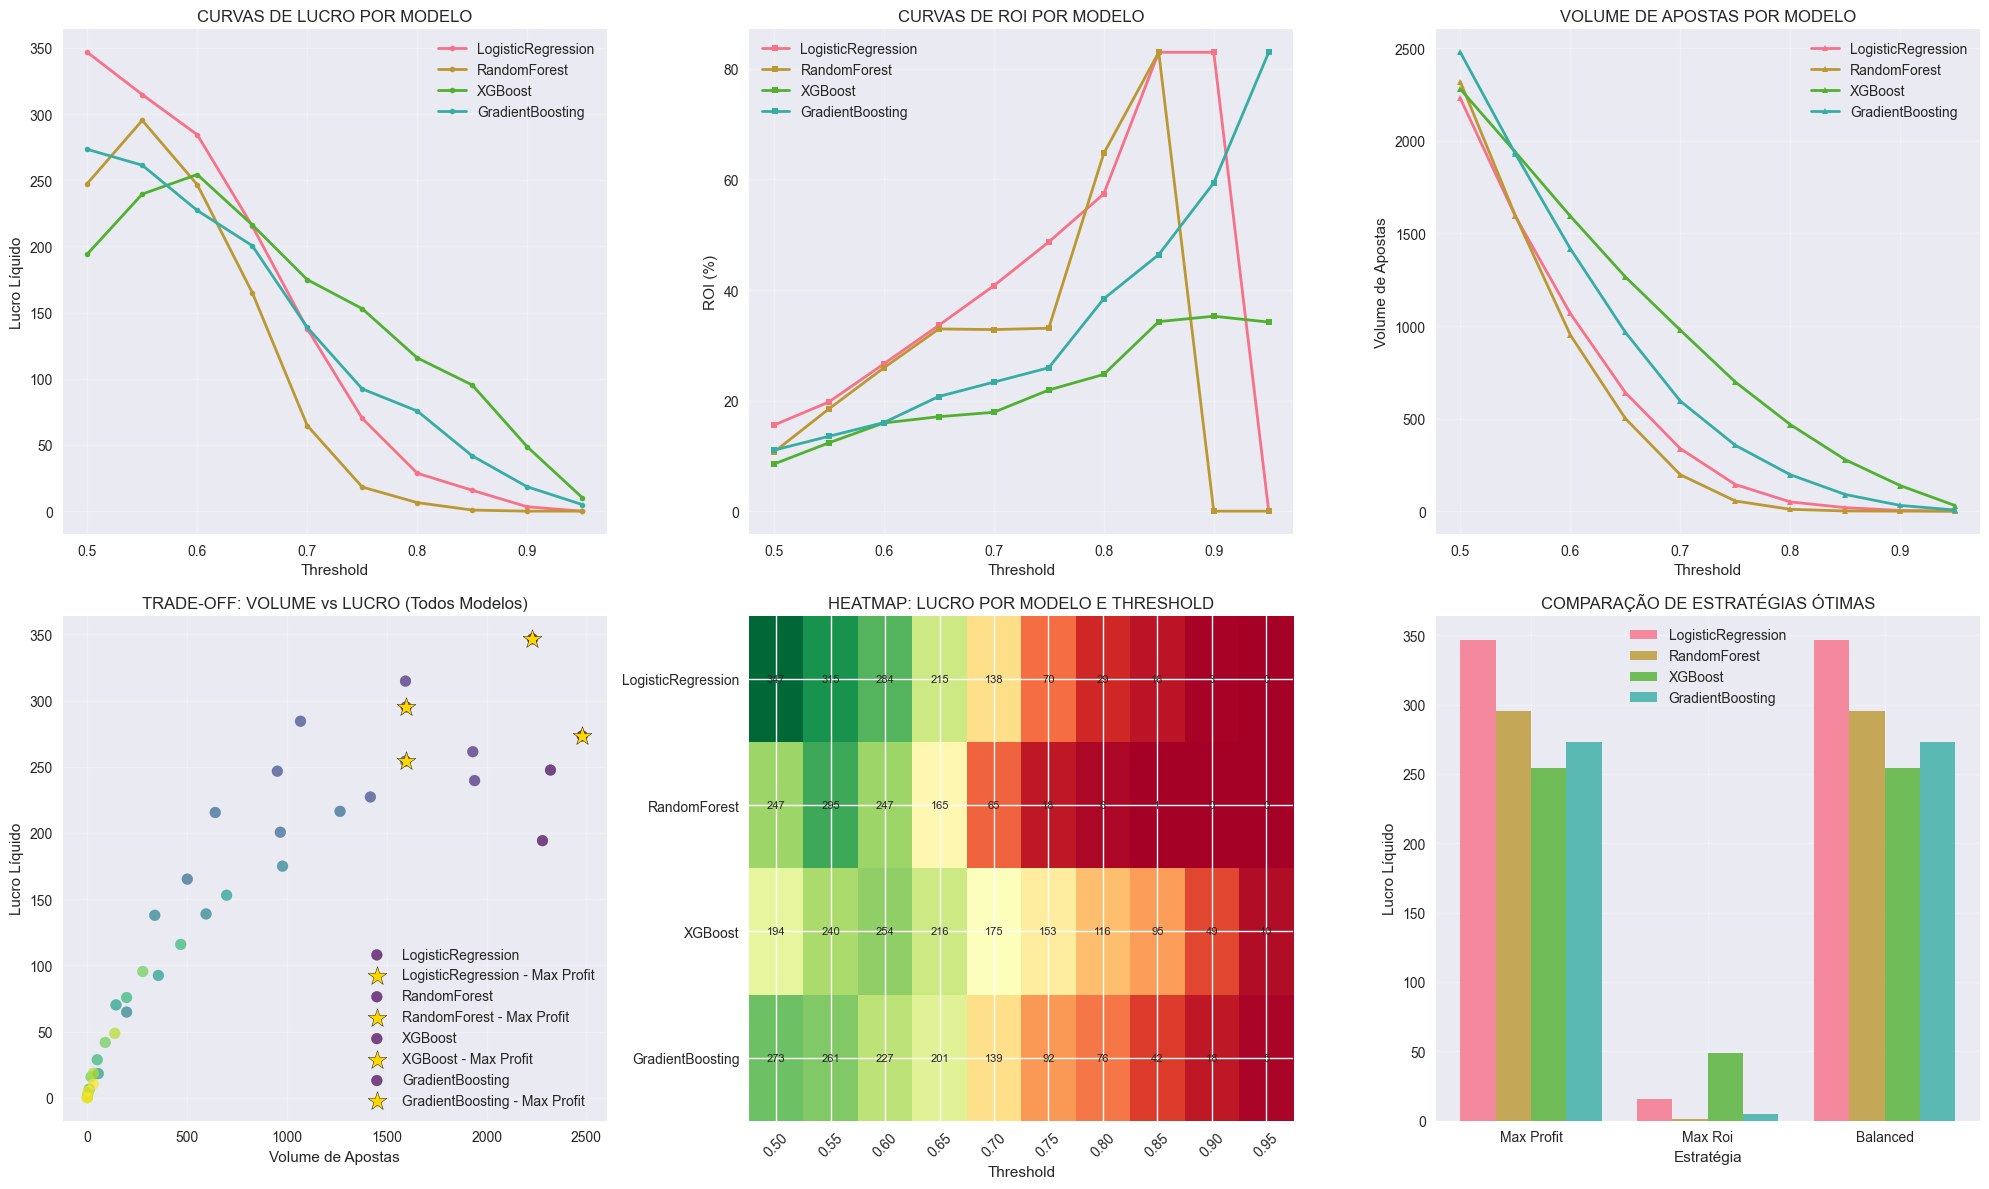


📋 TABELAS DETALHADAS POR MODELO

📊 LogisticRegression - ANÁLISE COMPLETA DE THRESHOLDS


,Threshold,Lucro,ROI,Apostas,Win_Rate,Freq_Apostas
0,0.50,346.64,15.5,2230,63.1,51.5
1,0.55,314.69,19.7,1594,65.4,36.8
2,0.60,284.37,26.6,1068,69.2,24.7
3,0.65,215.44,33.6,641,73.0,14.8
4,0.70,137.80,40.8,338,76.9,7.8
5,0.75,70.11,48.7,144,81.2,3.3
6,0.80,28.69,57.4,50,86.0,1.2
7,0.85,15.77,83.0,19,100.0,0.4
8,0.90,3.32,83.0,4,100.0,0.1
9,0.95,0.00,0.0,0,0.0,0.0



🎯 ESTRATÉGIAS RECOMENDADAS PARA LogisticRegression:
   💰 MAX LUCRO: threshold=0.50 | Lucro=346.6 | ROI=15.5% | Apostas=2230.0 | WinRate=63.1%
   📈 MAX ROI:   threshold=0.85 | Lucro=15.8 | ROI=83.0%
   ⚖️  BALANCEADO: threshold=0.50 | Lucro=346.6 | ROI=15.5%

📊 RandomForest - ANÁLISE COMPLETA DE THRESHOLDS


,Threshold,Lucro,ROI,Apostas,Win_Rate,Freq_Apostas
0,0.50,247.49,10.7,2320,60.5,53.6
1,0.55,295.22,18.5,1597,64.7,36.9
2,0.60,246.65,25.9,952,68.8,22.0
3,0.65,165.12,33.0,501,72.7,11.6
4,0.70,64.69,32.8,197,72.6,4.5
5,0.75,18.20,33.1,55,72.7,1.3
6,0.80,6.47,64.7,10,90.0,0.2
7,0.85,0.83,83.0,1,100.0,0.0
8,0.90,0.00,0.0,0,0.0,0.0
9,0.95,0.00,0.0,0,0.0,0.0



🎯 ESTRATÉGIAS RECOMENDADAS PARA RandomForest:
   💰 MAX LUCRO: threshold=0.55 | Lucro=295.2 | ROI=18.5% | Apostas=1597.0 | WinRate=64.7%
   📈 MAX ROI:   threshold=0.85 | Lucro=0.8 | ROI=83.0%
   ⚖️  BALANCEADO: threshold=0.55 | Lucro=295.2 | ROI=18.5%

📊 XGBoost - ANÁLISE COMPLETA DE THRESHOLDS


,Threshold,Lucro,ROI,Apostas,Win_Rate,Freq_Apostas
0,0.50,194.16,8.5,2280,59.3,52.6
1,0.55,239.53,12.3,1940,61.4,44.8
2,0.60,254.30,16.0,1594,63.4,36.8
3,0.65,216.30,17.1,1266,64.0,29.2
4,0.70,174.90,17.9,978,64.4,22.6
5,0.75,152.95,21.9,698,66.6,16.1
6,0.80,115.77,24.7,468,68.2,10.8
7,0.85,95.32,34.3,278,73.4,6.4
8,0.90,48.66,35.3,138,73.9,3.2
9,0.95,10.26,34.2,30,73.3,0.7



🎯 ESTRATÉGIAS RECOMENDADAS PARA XGBoost:
   💰 MAX LUCRO: threshold=0.60 | Lucro=254.3 | ROI=16.0% | Apostas=1594.0 | WinRate=63.4%
   📈 MAX ROI:   threshold=0.90 | Lucro=48.7 | ROI=35.3%
   ⚖️  BALANCEADO: threshold=0.60 | Lucro=254.3 | ROI=16.0%

📊 GradientBoosting - ANÁLISE COMPLETA DE THRESHOLDS


,Threshold,Lucro,ROI,Apostas,Win_Rate,Freq_Apostas
0,0.50,273.32,11.0,2479,60.7,57.2
1,0.55,261.34,13.5,1931,62.0,44.6
2,0.60,227.17,16.0,1418,63.4,32.7
3,0.65,200.54,20.7,967,66.0,22.3
4,0.70,138.83,23.3,595,67.4,13.7
5,0.75,92.35,25.9,356,68.8,8.2
6,0.80,75.67,38.4,197,75.6,4.5
7,0.85,41.76,46.4,90,80.0,2.1
8,0.90,18.41,59.4,31,87.1,0.7
9,0.95,4.98,83.0,6,100.0,0.1



🎯 ESTRATÉGIAS RECOMENDADAS PARA GradientBoosting:
   💰 MAX LUCRO: threshold=0.50 | Lucro=273.3 | ROI=11.0% | Apostas=2479.0 | WinRate=60.7%
   📈 MAX ROI:   threshold=0.95 | Lucro=5.0 | ROI=83.0%
   ⚖️  BALANCEADO: threshold=0.50 | Lucro=273.3 | ROI=11.0%

🏆 TABELA COMPARATIVA FINAL - MELHORES ESTRATÉGIAS


,Modelo,AUC,Melhor_Threshold,Lucro_Máximo,ROI_Máximo,Volume_Apostas,Win_Rate,Frequência_Apostas
0,LogisticRegression,0.651,0.500000,346.6,15.5%,2230,63.1%,51.5%
1,RandomForest,0.630,0.550000,295.2,18.5%,1597,64.7%,36.9%
3,GradientBoosting,0.622,0.500000,273.3,11.0%,2479,60.7%,57.2%
2,XGBoost,0.613,0.600000,254.3,16.0%,1594,63.4%,36.8%



🎯 TREINANDO MODELO FINAL (LogisticRegression)...

📊 PERFORMANCE NO TESTE:
   💰 Lucro: 72.8
   📈 ROI: 12.9%
   🎯 Apostas: 564
   ✅ Win Rate: 61.7%

✅ ANÁLISE COMPLETA CONCLUÍDA!


In [163]:
# === COMPARAÇÃO DE MÚLTIPLOS MODELOS COM ANÁLISE DETALHADA DE THRESHOLDS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# --- Garantias de variáveis do bloco anterior (todas as features) ---
assert 'X_train' in globals() and 'X_test' in globals(), "X_train / X_test não encontrados."
assert 'y_train' in globals() and 'y_test' in globals(), "y_train / y_test não encontrados."

# Peso de classe p/ XGBoost (neg/pos)
pos = float(np.sum(y_train))
neg = float(len(y_train) - pos)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# Definir múltiplos modelos para teste (todas as features)
models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
    ]),
    'RandomForest': Pipeline([
        ('model', RandomForestClassifier(
            n_estimators=200,
            max_depth=12,
            min_samples_split=10,
            random_state=42,
            class_weight='balanced'
        ))
    ]),
    'XGBoost': Pipeline([
        ('model', XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.07,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            reg_lambda=1.0,
            scale_pos_weight=scale_pos_weight,
            eval_metric='logloss',
            n_jobs=-1
        ))
    ]),
    'GradientBoosting': Pipeline([
        ('model', GradientBoostingClassifier(
            n_estimators=200,
            max_depth=3,
            random_state=42
        ))
    ])
}

# Configurações
cross_validator = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
ODDS = 1.83
strategic_thresholds = np.round(np.arange(0.50, 0.96, 0.05), 2)

print("🎯 ANÁLISE COMPLETA DE MODELOS E THRESHOLDS")
print("=" * 60)

# Resultados por modelo
model_results = {}

# >>>> usa TODAS as features: X_train / X_test
X_train_used, X_test_used = X_train, X_test

for model_name, model_pipeline in models.items():
    print(f"\n🔧 TREINANDO {model_name}...")
    
    # Validação cruzada (OOF)
    oof_predictions = np.zeros(len(X_train_used), dtype=float)
    
    for fold_idx, (train_idx, val_idx) in enumerate(cross_validator.split(X_train_used, y_train)):
        X_tr, X_val = X_train_used.iloc[train_idx], X_train_used.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model_fold = clone(model_pipeline)
        model_fold.fit(X_tr, y_tr)
        y_pred_proba = model_fold.predict_proba(X_val)[:, 1]
        oof_predictions[val_idx] = y_pred_proba
    
    # Análise de thresholds no OOF
    threshold_rows = []
    for threshold in strategic_thresholds:
        metrics = calculate_betting_metrics(y_train, oof_predictions, threshold, ODDS)
        threshold_rows.append({
            'threshold': threshold,
            'net_profit': metrics['net_profit'],
            'roi': metrics['return_on_investment'],
            'total_bets': metrics['total_bets'],
            'win_rate': metrics['win_rate'],
            'betting_frequency': metrics['total_bets'] / len(y_train)
        })
    threshold_df = pd.DataFrame(threshold_rows)

    # Estratégias
    max_profit = threshold_df.loc[threshold_df['net_profit'].idxmax()]
    max_roi = threshold_df.loc[threshold_df['roi'].idxmax()]
    viable = threshold_df[threshold_df['total_bets'] >= len(y_train) * 0.05]
    balanced = viable.loc[viable['net_profit'].idxmax()] if len(viable) > 0 else max_profit
    
    model_results[model_name] = {
        'oof_predictions': oof_predictions,
        'threshold_analysis': threshold_df,
        'strategies': {
            'max_profit': max_profit,
            'max_roi': max_roi,
            'balanced': balanced
        },
        'auc': roc_auc_score(y_train, oof_predictions)
    }
    
    print(f"   ✅ {model_name} - AUC: {model_results[model_name]['auc']:.3f}")
    print(f"   💰 Max Profit: thresh={max_profit['threshold']:.2f}, profit={max_profit['net_profit']:.1f}")
    print(f"   📈 Max ROI:    thresh={max_roi['threshold']:.2f}, roi={max_roi['roi']:.1f}%")
    print(f"   ⚖️  Balanced:  thresh={balanced['threshold']:.2f}, profit={balanced['net_profit']:.1f}")

# === Visualizações comparativas ===
print(f"\n{'='*60}")
print("📊 ANÁLISE DETALHADA POR MODELO E THRESHOLD")
print(f"{'='*60}")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1) Curvas de Lucro
for name, res in model_results.items():
    axes[0, 0].plot(res['threshold_analysis']['threshold'],
                    res['threshold_analysis']['net_profit'],
                    linewidth=2, marker='o', markersize=4, label=name)
axes[0, 0].set_xlabel('Threshold'); axes[0, 0].set_ylabel('Lucro Líquido')
axes[0, 0].set_title('CURVAS DE LUCRO POR MODELO'); axes[0, 0].legend(); axes[0, 0].grid(alpha=0.3)

# 2) Curvas de ROI
for name, res in model_results.items():
    axes[0, 1].plot(res['threshold_analysis']['threshold'],
                    res['threshold_analysis']['roi'],
                    linewidth=2, marker='s', markersize=4, label=name)
axes[0, 1].set_xlabel('Threshold'); axes[0, 1].set_ylabel('ROI (%)')
axes[0, 1].set_title('CURVAS DE ROI POR MODELO'); axes[0, 1].legend(); axes[0, 1].grid(alpha=0.3)

# 3) Volume
for name, res in model_results.items():
    axes[0, 2].plot(res['threshold_analysis']['threshold'],
                    res['threshold_analysis']['total_bets'],
                    linewidth=2, marker='^', markersize=4, label=name)
axes[0, 2].set_xlabel('Threshold'); axes[0, 2].set_ylabel('Volume de Apostas')
axes[0, 2].set_title('VOLUME DE APOSTAS POR MODELO'); axes[0, 2].legend(); axes[0, 2].grid(alpha=0.3)

# 4) Trade-off Volume vs Lucro
for name, res in model_results.items():
    axes[1, 0].scatter(res['threshold_analysis']['total_bets'],
                       res['threshold_analysis']['net_profit'],
                       c=res['threshold_analysis']['threshold'],
                       s=60, cmap='viridis', alpha=0.7, label=name)
    strat = res['strategies']['max_profit']
    axes[1, 0].scatter(strat['total_bets'], strat['net_profit'],
                       s=200, marker='*', color='gold', edgecolors='black',
                       label=f"{name} - Max Profit")
axes[1, 0].set_xlabel('Volume de Apostas'); axes[1, 0].set_ylabel('Lucro Líquido')
axes[1, 0].set_title('TRADE-OFF: VOLUME vs LUCRO (Todos Modelos)')
axes[1, 0].legend(); axes[1, 0].grid(alpha=0.3)

# 5) Heatmap Lucro por Threshold
model_names = list(model_results.keys())
threshold_matrix = np.array([
    model_results[m]['threshold_analysis']['net_profit'].values for m in model_names
])
im = axes[1, 1].imshow(threshold_matrix, cmap='RdYlGn', aspect='auto', interpolation='nearest')
axes[1, 1].set_xticks(range(len(strategic_thresholds)))
axes[1, 1].set_xticklabels([f'{t:.2f}' for t in strategic_thresholds], rotation=45)
axes[1, 1].set_yticks(range(len(model_names)))
axes[1, 1].set_yticklabels(model_names)
axes[1, 1].set_xlabel('Threshold'); axes[1, 1].set_title('HEATMAP: LUCRO POR MODELO E THRESHOLD')
for i in range(len(model_names)):
    for j in range(len(strategic_thresholds)):
        axes[1, 1].text(j, i, f'{threshold_matrix[i, j]:.0f}', ha="center", va="center", fontsize=8)

# 6) Comparação de estratégias (lucro)
strategies_comparison = []
for name, res in model_results.items():
    for strat_name, strat in res['strategies'].items():
        strategies_comparison.append({
            'Modelo': name,
            'Estratégia': strat_name.replace('_', ' ').title(),
            'Threshold': strat['threshold'],
            'Lucro': strat['net_profit'],
            'ROI': strat['roi'],
            'Volume': strat['total_bets']
        })
strategies_df = pd.DataFrame(strategies_comparison)
strategy_types = strategies_df['Estratégia'].unique()
x = np.arange(len(strategy_types)); width = 0.2
for idx, name in enumerate(model_names):
    mdata = strategies_df[strategies_df['Modelo'] == name]
    profits = [mdata[mdata['Estratégia'] == st]['Lucro'].values[0] for st in strategy_types]
    axes[1, 2].bar(x + idx*width, profits, width, label=name, alpha=0.8)
axes[1, 2].set_xlabel('Estratégia'); axes[1, 2].set_ylabel('Lucro Líquido')
axes[1, 2].set_title('COMPARAÇÃO DE ESTRATÉGIAS ÓTIMAS')
axes[1, 2].set_xticks(x + width*1.5); axes[1, 2].set_xticklabels(strategy_types)
axes[1, 2].legend(); axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === TABELAS DETALHADAS POR MODELO ===
from IPython.display import display
print(f"\n📋 TABELAS DETALHADAS POR MODELO")
for name, res in model_results.items():
    print(f"\n{'='*50}")
    print(f"📊 {name} - ANÁLISE COMPLETA DE THRESHOLDS")
    print(f"{'='*50}")
    display_df = res['threshold_analysis'].copy()
    display_df['Win_Rate'] = (display_df['win_rate'] * 100).round(1)
    display_df['Freq_Apostas'] = (display_df['betting_frequency'] * 100).round(1)
    display_df['ROI'] = display_df['roi'].round(1)
    final_display = display_df[['threshold','net_profit','ROI','total_bets','Win_Rate','Freq_Apostas']].rename(
        columns={'threshold':'Threshold','net_profit':'Lucro','total_bets':'Apostas'}
    ).round(2)
    display(final_display)

    s = res['strategies']
    print(f"\n🎯 ESTRATÉGIAS RECOMENDADAS PARA {name}:")
    print(f"   💰 MAX LUCRO: threshold={s['max_profit']['threshold']:.2f} | Lucro={s['max_profit']['net_profit']:.1f} | ROI={s['max_profit']['roi']:.1f}% | Apostas={s['max_profit']['total_bets']} | WinRate={s['max_profit']['win_rate']:.1%}")
    print(f"   📈 MAX ROI:   threshold={s['max_roi']['threshold']:.2f} | Lucro={s['max_roi']['net_profit']:.1f} | ROI={s['max_roi']['roi']:.1f}%")
    print(f"   ⚖️  BALANCEADO: threshold={s['balanced']['threshold']:.2f} | Lucro={s['balanced']['net_profit']:.1f} | ROI={s['balanced']['roi']:.1f}%")

# === TABELA COMPARATIVA FINAL ===
print(f"\n{'='*60}")
print("🏆 TABELA COMPARATIVA FINAL - MELHORES ESTRATÉGIAS")
print(f"{'='*60}")

comparison_data = []
for name, res in model_results.items():
    best = res['strategies']['max_profit']
    comparison_data.append({
        'Modelo': name,
        'AUC': f"{res['auc']:.3f}",
        'Melhor_Threshold': best['threshold'],
        'Lucro_Máximo': best['net_profit'],
        'ROI_Máximo': f"{best['roi']:.1f}%",
        'Volume_Apostas': best['total_bets'],
        'Win_Rate': f"{best['win_rate']:.1%}",
        'Frequência_Apostas': f"{best['betting_frequency']:.1%}"
    })
comparison_df = pd.DataFrame(comparison_data).sort_values('Lucro_Máximo', ascending=False)
display(comparison_df.style.background_gradient(subset=['Lucro_Máximo'], cmap='RdYlGn').format({
    'Lucro_Máximo':'{:.1f}', 'Volume_Apostas':'{:.0f}'
}))

# === SELECIONAR E TREINAR MODELO FINAL ===
best_overall_profit = -np.inf
best_model_name, best_threshold = None, None
for name, res in model_results.items():
    strat = res['strategies']['max_profit']
    if strat['net_profit'] > best_overall_profit:
        best_overall_profit = strat['net_profit']
        best_model_name = name
        best_threshold = strat['threshold']

print(f"\n🎯 TREINANDO MODELO FINAL ({best_model_name})...")
final_model = clone(models[best_model_name])
final_model.fit(X_train, y_train)  # <<<<<< usa TODAS as features

# Avaliar no teste
y_test_pred = final_model.predict_proba(X_test)[:, 1]
test_metrics = calculate_betting_metrics(y_test, y_test_pred, best_threshold, ODDS)

print(f"\n📊 PERFORMANCE NO TESTE:")
print(f"   💰 Lucro: {test_metrics['net_profit']:.1f}")
print(f"   📈 ROI: {test_metrics['return_on_investment']:.1f}%")
print(f"   🎯 Apostas: {test_metrics['total_bets']}")
print(f"   ✅ Win Rate: {test_metrics['win_rate']:.1%}")

# Importâncias (quando aplicável)
feature_info = None
try:
    base = getattr(final_model, 'named_steps', None)
    base_model = base.get('model') if base else final_model
    if hasattr(base_model, 'feature_importances_'):
        feature_info = dict(zip(X_train.columns, base_model.feature_importances_.tolist()))
    elif hasattr(base_model, 'coef_'):
        feature_info = dict(zip(X_train.columns, base_model.coef_[0].tolist()))
except Exception:
    feature_info = None

final_results = {
    'model': final_model,
    'model_name': best_model_name,
    'threshold': best_threshold,
    'test_metrics': test_metrics,
    'features_used': X_train.columns.tolist(),
    'feature_info': feature_info
}

print(f"\n✅ ANÁLISE COMPLETA CONCLUÍDA!")


🎯 SELECIONANDO MODELO FINAL: LogisticRegression com Threshold 0.60
✅ MODELO ESCOLHIDO: LogisticRegression
🎯 THRESHOLD ESCOLHIDO: 0.6
📊 MÉTRICAS ESPERADAS NO TREINO:
   💰 Lucro Esperado: 284.4
   📈 ROI Esperado: 26.6%
   🎯 Volume de Apostas: 1068.0
   ✅ Win Rate: 69.2%
   📊 Frequência de Apostas: 24.7%

🔨 TREINANDO MODELO FINAL...

📊 AVALIAÇÃO NO CONJUNTO DE TESTE
🎯 RESULTADOS NO TESTE (Threshold 0.6):
   💰 Lucro Realizado: 75.7
   📈 ROI Realizado: 26.7%
   🎯 Apostas Realizadas: 283 (26.1% dos jogos)
   ✅ Win Rate Realizado: 69.3%
   📊 AUC-ROC: 0.638

📈 ANÁLISE DETALHADA DAS PREVISÕES
📊 Estatísticas das Probabilidades Previstas:
   Mínima: 0.015
   Máxima: 0.858
   Média: 0.505
   Desvio Padrão: 0.141

🎯 ANÁLISE POR FAIXAS DE PROBABILIDADE:


,Faixa_Prob,Jogos,Apostas,Win_Rate,Lucro,ROI
0,0.00-0.55,663,144,52.1%,-6.75,-4.7%
1,0.55-0.60,137,137,56.2%,3.91,2.9%
2,0.60-0.65,117,117,60.7%,12.93,11.1%
3,0.65-0.70,77,77,77.9%,32.80,42.6%
4,0.70-0.75,45,45,66.7%,9.90,22.0%
5,0.75-0.80,30,30,83.3%,15.75,52.5%
6,0.80-1.00,14,14,71.4%,4.30,30.7%



📊 GERANDO VISUALIZAÇÕES DO MODELO FINAL...


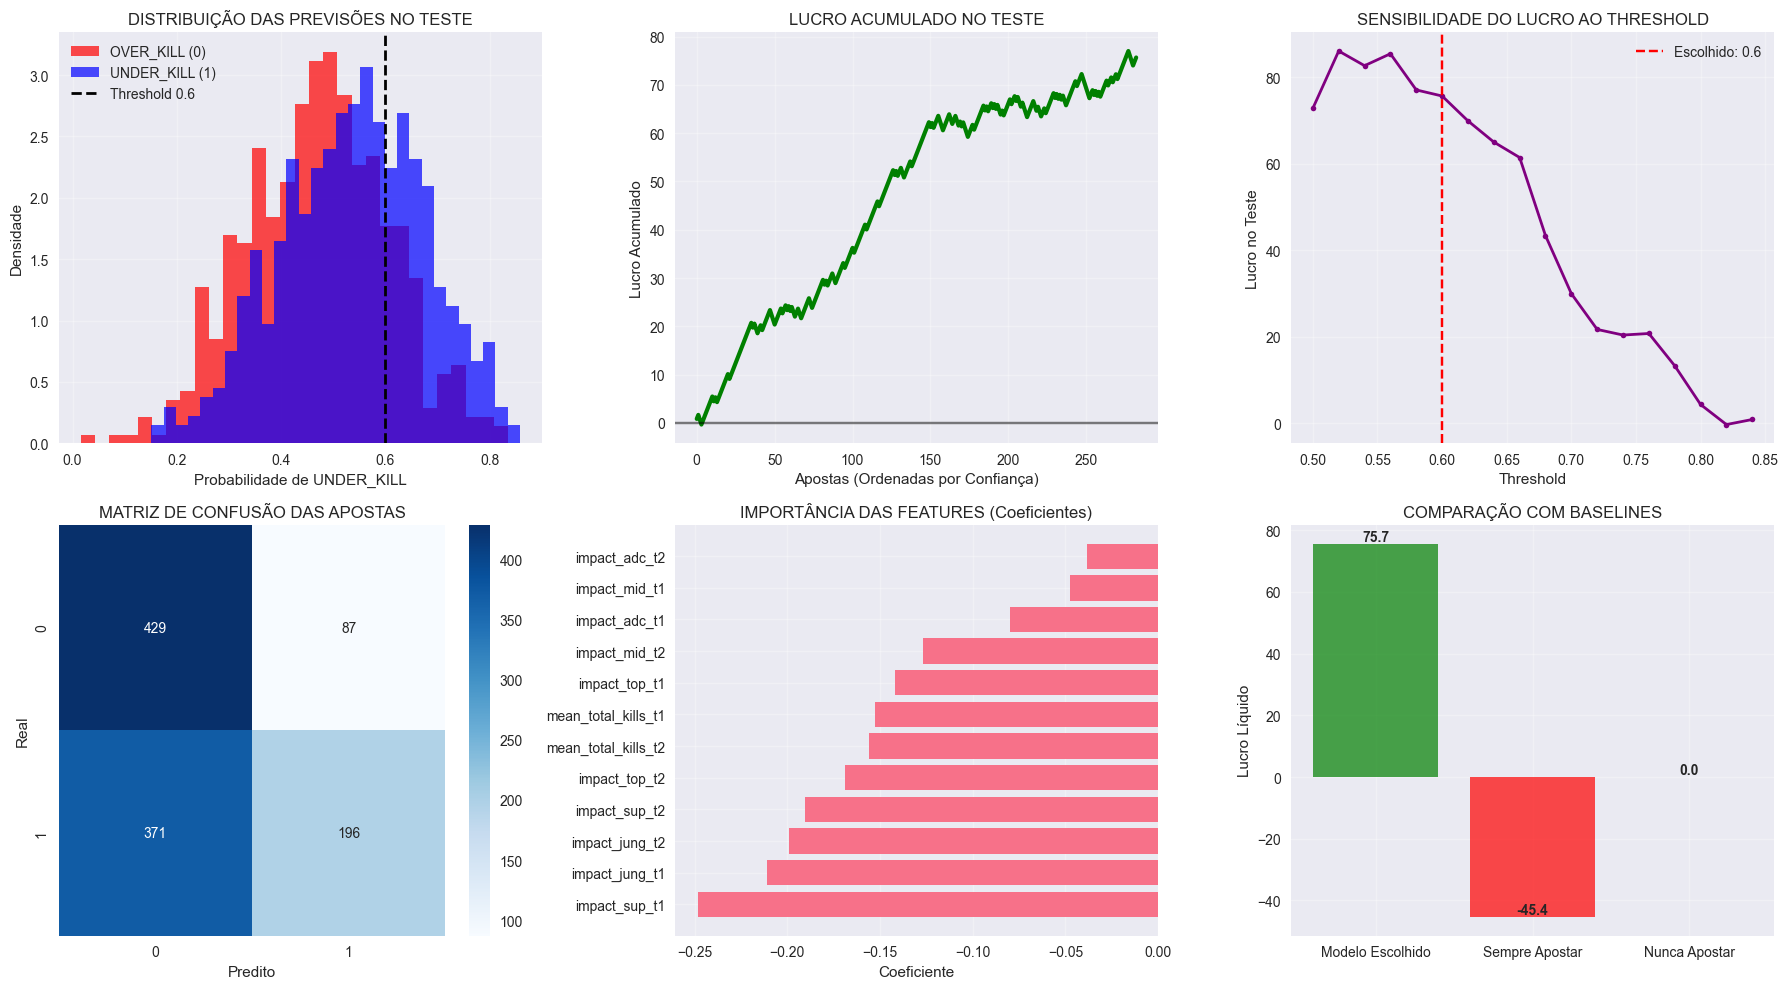


✅ MODELO FINAL CONFIGURADO E SALVO!
📁 RESUMO DA CONFIGURAÇÃO:
   🎯 Modelo: LogisticRegression
   📊 Threshold: 0.6
   💰 Odds: 1.83
   🔧 Features: 12
   📈 Performance no Teste: 75.7 de lucro

🎯 PRÓXIMOS PASSOS:
   1. O modelo está pronto para fazer previsões em novos dados
   2. Use threshold 0.6 para decisões de aposta
   3. Monitore performance com novos dados

🎲 FUNÇÃO 'fazer_aposta()' DISPONÍVEL PARA USO!
   💡 Use para fazer previsões em novos jogos


In [164]:
# === ESCOLHA DO MODELO FINAL: LogisticRegression com Threshold 0.60 ===

print("🎯 SELECIONANDO MODELO FINAL: LogisticRegression com Threshold 0.60")
print("=" * 60)

# Definir modelo e threshold escolhidos
MODELO_ESCOLHIDO = "LogisticRegression"
THRESHOLD_ESCOLHIDO = 0.60

# Recuperar os resultados do modelo escolhido
modelo_resultados = model_results[MODELO_ESCOLHIDO]
threshold_analysis = modelo_resultados["threshold_analysis"]

# Encontrar as métricas exatas para o threshold 0.60
threshold_60_metrics = threshold_analysis[
    threshold_analysis["threshold"] == THRESHOLD_ESCOLHIDO
].iloc[0]

print(f"✅ MODELO ESCOLHIDO: {MODELO_ESCOLHIDO}")
print(f"🎯 THRESHOLD ESCOLHIDO: {THRESHOLD_ESCOLHIDO}")
print(f"📊 MÉTRICAS ESPERADAS NO TREINO:")
print(f"   💰 Lucro Esperado: {threshold_60_metrics['net_profit']:.1f}")
print(f"   📈 ROI Esperado: {threshold_60_metrics['roi']:.1f}%")
print(f"   🎯 Volume de Apostas: {threshold_60_metrics['total_bets']}")
print(f"   ✅ Win Rate: {threshold_60_metrics['win_rate']:.1%}")
print(f"   📊 Frequência de Apostas: {threshold_60_metrics['betting_frequency']:.1%}")

# === TREINAR MODELO FINAL COM TODOS OS DADOS DE TREINO ===

print(f"\n🔨 TREINANDO MODELO FINAL...")

# Criar e treinar o modelo final
final_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000),
        ),
    ]
)

# Treinar com todos os dados de treino
final_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# === AVALIAÇÃO NO CONJUNTO DE TESTE ===

print(f"\n📊 AVALIAÇÃO NO CONJUNTO DE TESTE")

# Calcular métricas de apostas no teste
test_betting_metrics = calculate_betting_metrics(
    y_test, y_test_pred_proba, THRESHOLD_ESCOLHIDO, ODDS
)

# Calcular métricas probabilísticas
test_prob_metrics = evaluate_probabilistic_metrics(y_test, y_test_pred_proba)

print(f"🎯 RESULTADOS NO TESTE (Threshold {THRESHOLD_ESCOLHIDO}):")
print(f"   💰 Lucro Realizado: {test_betting_metrics['net_profit']:.1f}")
print(f"   📈 ROI Realizado: {test_betting_metrics['return_on_investment']:.1f}%")
print(
    f"   🎯 Apostas Realizadas: {test_betting_metrics['total_bets']} ({test_betting_metrics['total_bets'] / len(y_test) * 100:.1f}% dos jogos)"
)
print(f"   ✅ Win Rate Realizado: {test_betting_metrics['win_rate']:.1%}")
print(f"   📊 AUC-ROC: {test_prob_metrics['auc_roc']:.3f}")

# === ANÁLISE DETALHADA DAS PREVISÕES ===

print(f"\n📈 ANÁLISE DETALHADA DAS PREVISÕES")

# Calcular estatísticas das probabilidades previstas
prob_stats = {
    "min": y_test_pred_proba.min(),
    "max": y_test_pred_proba.max(),
    "mean": y_test_pred_proba.mean(),
    "std": y_test_pred_proba.std(),
}

print(f"📊 Estatísticas das Probabilidades Previstas:")
print(f"   Mínima: {prob_stats['min']:.3f}")
print(f"   Máxima: {prob_stats['max']:.3f}")
print(f"   Média: {prob_stats['mean']:.3f}")
print(f"   Desvio Padrão: {prob_stats['std']:.3f}")

# Análise por faixas de probabilidade
print(f"\n🎯 ANÁLISE POR FAIXAS DE PROBABILIDADE:")

prob_bins = [0.0, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 1.0]
bin_analysis = []

for i in range(len(prob_bins) - 1):
    low, high = prob_bins[i], prob_bins[i + 1]
    mask = (y_test_pred_proba >= low) & (y_test_pred_proba < high)

    if mask.sum() > 0:
        bin_metrics = calculate_betting_metrics(
            y_test[mask],
            y_test_pred_proba[mask],
            0.5,
            ODDS,  # Threshold 0.5 para análise binária
        )
        bin_analysis.append(
            {
                "Faixa_Prob": f"{low:.2f}-{high:.2f}",
                "Jogos": mask.sum(),
                "Apostas": bin_metrics["total_bets"],
                "Win_Rate": f"{bin_metrics['win_rate']:.1%}",
                "Lucro": bin_metrics["net_profit"],
                "ROI": f"{bin_metrics['return_on_investment']:.1f}%",
            }
        )

bin_df = pd.DataFrame(bin_analysis)
if not bin_df.empty:
    display(bin_df)

# === VISUALIZAÇÕES DO MODELO FINAL ===

print(f"\n📊 GERANDO VISUALIZAÇÕES DO MODELO FINAL...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Gráfico 1: Distribuição das Probabilidades no Teste
axes[0, 0].hist(
    y_test_pred_proba[y_test == 0],
    bins=30,
    alpha=0.7,
    label="OVER_KILL (0)",
    color="red",
    density=True,
)
axes[0, 0].hist(
    y_test_pred_proba[y_test == 1],
    bins=30,
    alpha=0.7,
    label="UNDER_KILL (1)",
    color="blue",
    density=True,
)
axes[0, 0].axvline(
    THRESHOLD_ESCOLHIDO,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Threshold {THRESHOLD_ESCOLHIDO}",
)
axes[0, 0].set_xlabel("Probabilidade de UNDER_KILL")
axes[0, 0].set_ylabel("Densidade")
axes[0, 0].set_title("DISTRIBUIÇÃO DAS PREVISÕES NO TESTE")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Gráfico 2: Curva de Lucro Acumulado no Teste
bet_mask = y_test_pred_proba >= THRESHOLD_ESCOLHIDO
bet_probs = y_test_pred_proba[bet_mask]
bet_true = y_test[bet_mask]

# Ordenar por confiança (mais confiáveis primeiro)
sort_idx = np.argsort(bet_probs)[::-1]
sorted_true = bet_true[sort_idx]

# Calcular lucro acumulado
profit_per_bet = np.where(sorted_true == 1, ODDS - 1, -1)
cumulative_profit = np.cumsum(profit_per_bet)

axes[0, 1].plot(
    range(len(cumulative_profit)), cumulative_profit, linewidth=3, color="green"
)
axes[0, 1].axhline(0, color="black", linestyle="-", alpha=0.5)
axes[0, 1].set_xlabel("Apostas (Ordenadas por Confiança)")
axes[0, 1].set_ylabel("Lucro Acumulado")
axes[0, 1].set_title("LUCRO ACUMULADO NO TESTE")
axes[0, 1].grid(alpha=0.3)

# Gráfico 3: Análise de Sensibilidade do Threshold no Teste
test_thresholds = np.arange(0.50, 0.85, 0.02)
test_profits = []

for thr in test_thresholds:
    metrics = calculate_betting_metrics(y_test, y_test_pred_proba, thr, ODDS)
    test_profits.append(metrics["net_profit"])

axes[0, 2].plot(
    test_thresholds, test_profits, "o-", linewidth=2, markersize=4, color="purple"
)
axes[0, 2].axvline(
    THRESHOLD_ESCOLHIDO,
    color="red",
    linestyle="--",
    label=f"Escolhido: {THRESHOLD_ESCOLHIDO}",
)
axes[0, 2].set_xlabel("Threshold")
axes[0, 2].set_ylabel("Lucro no Teste")
axes[0, 2].set_title("SENSIBILIDADE DO LUCRO AO THRESHOLD")
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Gráfico 4: Matriz de Confusão das Apostas
from sklearn.metrics import confusion_matrix
import seaborn as sns

bet_decisions = (y_test_pred_proba >= THRESHOLD_ESCOLHIDO).astype(int)
cm = confusion_matrix(y_test, bet_decisions)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_xlabel("Predito")
axes[1, 0].set_ylabel("Real")
axes[1, 0].set_title("MATRIZ DE CONFUSÃO DAS APOSTAS")

# Gráfico 5: Coeficientes do Modelo (Feature Importance)
if hasattr(final_model.named_steps["model"], "coef_"):
    feature_importance = pd.DataFrame(
        {
            "feature": X_train.columns,
            "importance": final_model.named_steps["model"].coef_[0],
        }
    ).sort_values("importance", ascending=True)

    axes[1, 1].barh(feature_importance["feature"], feature_importance["importance"])
    axes[1, 1].set_xlabel("Coeficiente")
    axes[1, 1].set_title("IMPORTÂNCIA DAS FEATURES (Coeficientes)")
    axes[1, 1].grid(alpha=0.3)

# Gráfico 6: Comparação com Baseline
baseline_metrics = calculate_betting_metrics(
    y_test,
    np.ones_like(y_test_pred_proba),
    0.5,
    ODDS,  # Sempre apostar
)

comparison_data = {
    "Modelo Escolhido": test_betting_metrics["net_profit"],
    "Sempre Apostar": baseline_metrics["net_profit"],
    "Nunca Apostar": 0,  # Baseline zero
}

axes[1, 2].bar(
    comparison_data.keys(),
    comparison_data.values(),
    color=["green", "red", "gray"],
    alpha=0.7,
)
axes[1, 2].set_ylabel("Lucro Líquido")
axes[1, 2].set_title("COMPARAÇÃO COM BASELINES")
axes[1, 2].grid(alpha=0.3)

# Adicionar valores nas barras
for i, (label, value) in enumerate(comparison_data.items()):
    axes[1, 2].text(
        i, value, f"{value:.1f}", ha="center", va="bottom", fontweight="bold"
    )

plt.tight_layout()
plt.show()

# === SALVAR MODELO FINAL E CONFIGURAÇÕES ===

final_results = {
    "model": final_model,
    "model_name": MODELO_ESCOLHIDO,
    "threshold": THRESHOLD_ESCOLHIDO,
    "odds": ODDS,
    "features_used": X_train.columns.tolist(),
    "test_metrics": test_betting_metrics,
    "test_prob_metrics": test_prob_metrics,
    "training_size": len(X_train),
    "feature_analysis": feature_importance.to_dict("records")
    if "feature_importance" in locals()
    else None,
}

print(f"\n✅ MODELO FINAL CONFIGURADO E SALVO!")
print(f"📁 RESUMO DA CONFIGURAÇÃO:")
print(f"   🎯 Modelo: {final_results['model_name']}")
print(f"   📊 Threshold: {final_results['threshold']}")
print(f"   💰 Odds: {final_results['odds']}")
print(f"   🔧 Features: {len(final_results['features_used'])}")
print(
    f"   📈 Performance no Teste: {final_results['test_metrics']['net_profit']:.1f} de lucro"
)

print(f"\n🎯 PRÓXIMOS PASSOS:")
print(f"   1. O modelo está pronto para fazer previsões em novos dados")
print(f"   2. Use threshold {THRESHOLD_ESCOLHIDO} para decisões de aposta")
print(f"   3. Monitore performance com novos dados")

# === FUNÇÃO PARA FAZER PREVISÕES EM NOVOS DADOS ===


def fazer_aposta(
    novos_dados, modelo=final_model, threshold=THRESHOLD_ESCOLHIDO, odds=ODDS
):
    """
    Função para fazer previsões em novos dados e recomendar apostas.

    Args:
        novos_dados: DataFrame com as mesmas features do treino
        modelo: Modelo treinado
        threshold: Threshold para decisão de aposta
        odds: Odds oferecidas

    Returns:
        DataFrame com previsões e recomendações
    """
    # Fazer previsões
    probabilidades = modelo.predict_proba(novos_dados)[:, 1]

    # Calcular valor esperado
    valor_esperado = probabilidades * (odds - 1) - (1 - probabilidades)

    # Criar resultados
    resultados = pd.DataFrame(
        {
            "probabilidade_under": probabilidades,
            "valor_esperado": valor_esperado,
            "recomendacao_aposta": probabilidades >= threshold,
            "confianca": np.where(probabilidades >= threshold, "ALTA", "BAIXA"),
        }
    )

    # Ordenar por valor esperado (melhores apostas primeiro)
    resultados = resultados.sort_values("valor_esperado", ascending=False)

    return resultados


print(f"\n🎲 FUNÇÃO 'fazer_aposta()' DISPONÍVEL PARA USO!")
print(f"   💡 Use para fazer previsões em novos jogos")

In [165]:
# %% === SALVAMENTO DO MODELO TREINADO (NOMES ATUALIZADOS) ===
import joblib
import pandas as pd
from sklearn.metrics import roc_auc_score

# --- Verificações e fallbacks de variáveis usadas acima ---
assert "final_model" in globals(), "final_model não encontrado. Treine o modelo final antes."
assert "X_train" in globals(), "X_train não encontrado."
assert "y_test" in globals(), "y_test não encontrado."
assert "ODDS" in globals(), "ODDS não definido."

# Threshold escolhido: usa best_threshold se existir, senão THRESHOLD_ESCOLHIDO
CHOSEN_THRESHOLD = 0.6
assert CHOSEN_THRESHOLD is not None, "Threshold escolhido não encontrado (best_threshold/THRESHOLD_ESCOLHIDO)."

# AUC e métricas de teste:
# Preferir 'test_prob_metrics' e 'test_betting_metrics' se existirem;
# caso contrário, recomputar a partir de y_test_pred e test_metrics.
y_test_pred = globals().get("y_test_pred", None)
if y_test_pred is None:
    # tenta prever para obter y_test_pred
    y_test_pred = final_model.predict_proba(globals().get("X_test", X_train).iloc[:len(y_test)])[:, 1]

# AUC
if "test_prob_metrics" in globals() and "auc_roc" in test_prob_metrics:
    TEST_AUC = float(test_prob_metrics["auc_roc"])
else:
    TEST_AUC = float(roc_auc_score(y_test, y_test_pred))

# Métricas de aposta
if "test_betting_metrics" in globals():
    TEST_PROFIT = float(test_betting_metrics["net_profit"])
    TEST_ROI = float(test_betting_metrics["return_on_investment"])
elif "test_metrics" in globals():
    TEST_PROFIT = float(test_metrics["net_profit"])
    TEST_ROI = float(test_metrics["return_on_investment"])
else:
    # Fallback: calcular rapidamente com a função já usada no pipeline
    assert "calculate_betting_metrics" in globals(), "Função calculate_betting_metrics não encontrada para recomputar métricas."
    tmp = calculate_betting_metrics(y_test, y_test_pred, CHOSEN_THRESHOLD, ODDS)
    TEST_PROFIT = float(tmp["net_profit"])
    TEST_ROI = float(tmp["return_on_investment"])

# Nome do modelo
if "final_results" in globals() and isinstance(final_results, dict) and "model_name" in final_results:
    MODEL_NAME = str(final_results["model_name"])
elif "best_model_name" in globals():
    MODEL_NAME = str(best_model_name)
else:
    # tenta extrair do pipeline
    try:
        base = getattr(final_model, "named_steps", None)
        mdl = base.get("model") if base else final_model
        MODEL_NAME = mdl.__class__.__name__
    except Exception:
        MODEL_NAME = "Model"

# Caminhos
MODEL_PATH = "betting_model_pipeline_under.pkl"
INFO_PATH = "model_info_under.pkl"

# Salva o pipeline completo (scaler + modelo)
joblib.dump(final_model, MODEL_PATH)

# Probabilidade de break-even (EV=0) para odds decimais
breakeven_probability = 1.0 / float(ODDS)

model_info = {
    "model_name": MODEL_NAME,
    "feature_columns": list(X_train.columns),
    "chosen_threshold": float(CHOSEN_THRESHOLD),
    "odds": float(ODDS),
    "breakeven_probability": float(breakeven_probability),
    "test_auc": TEST_AUC,
    "test_profit": TEST_PROFIT,
    "test_roi": TEST_ROI,
    "training_size": int(len(X_train)),
    "created_at_utc": pd.Timestamp.utcnow().isoformat(),
}

joblib.dump(model_info, INFO_PATH)

print("✅ Modelo salvo com sucesso!")
print(f"   📁 Pipeline: {MODEL_PATH}")
print(f"   📁 Informações: {INFO_PATH}")

# --- Smoke test: carregar e prever para garantir integridade ---
try:
    _loaded_model = joblib.load(MODEL_PATH)
    _probe_source = globals().get("X_test", X_train)
    _probe_X = _probe_source.iloc[:5]
    _ = _loaded_model.predict_proba(_probe_X)
    _loaded_info = joblib.load(INFO_PATH)
    print("🔎 Verificação: pipeline e model_info carregados e funcionando.")
    print(f"   🔧 Features salvas: {_loaded_info['feature_columns'][:3]} ... "
          f"(+{max(0, len(_loaded_info['feature_columns']) - 3)})")
    print(f"   🎯 Threshold salvo: {_loaded_info['chosen_threshold']}")
except Exception as e:
    print("⚠️ Falha no smoke test de carregamento/predição:", repr(e))


✅ Modelo salvo com sucesso!
   📁 Pipeline: betting_model_pipeline_under.pkl
   📁 Informações: model_info_under.pkl
🔎 Verificação: pipeline e model_info carregados e funcionando.
   🔧 Features salvas: ['mean_total_kills_t1', 'mean_total_kills_t2', 'impact_top_t1'] ... (+9)
   🎯 Threshold salvo: 0.6


# TESTE REAL DATA

In [166]:
dados_reais = pd.read_csv("real_data/data.csv")
# Básico
dados_reais.info()  # tipos, contagem por coluna, NaNs (non-null)
dados_reais.describe()  # estatísticas de numéricas
dados_reais.describe(include="all")  # inclui categóricas (contagem, únicos, topo, freq)

# Amostras
dados_reais.head()  # primeiras linhas
dados_reais.sample(5, random_state=42)  # amostra aleatória

# NaNs
dados_reais.isna().sum().sort_values(ascending=False)  # NaNs por coluna
(dados_reais.isna().mean() * 100).round(2).sort_values(ascending=False)  # % de NaNs

# Duplicadas
dados_reais.duplicated().sum()  # linhas duplicadas
dados_reais[dados_reais.duplicated()]  # ver duplicadas

# Cardinalidade e constantes
dados_reais.nunique().sort_values()  # únicos por coluna
[c for c in dados_reais.columns if dados_reais[c].nunique() <= 1]  # colunas constantes

# Memória
dados_reais.memory_usage(deep=True).sum() / 1024**2  # MB usados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_kills          389 non-null    int64  
 1   league_mean_kills    389 non-null    float64
 2   league               389 non-null    object 
 3   mean_total_kills_t1  364 non-null    float64
 4   mean_total_kills_t2  359 non-null    float64
 5   bet_line             389 non-null    object 
 6   bet_value            389 non-null    float64
 7   bet_status           389 non-null    object 
 8   house_odds           389 non-null    float64
 9   actual_value         375 non-null    float64
 10  impact_top_t1        389 non-null    float64
 11  impact_top_t2        389 non-null    float64
 12  impact_jung_t1       389 non-null    float64
 13  impact_jung_t2       389 non-null    float64
 14  impact_mid_t1        389 non-null    float64
 15  impact_mid_t2        389 non-null    flo

0.10933685302734375

In [167]:
dados_reais = df.dropna().copy()
# Básico
dados_reais.info()  # tipos, contagem por coluna, NaNs (non-null)
dados_reais.describe()  # estatísticas de numéricas
dados_reais.describe(include="all")  # inclui categóricas (contagem, únicos, topo, freq)

# Amostras
dados_reais.head()  # primeiras linhas
dados_reais.sample(5, random_state=42)  # amostra aleatória

# NaNs
dados_reais.isna().sum().sort_values(ascending=False)  # NaNs por coluna
(dados_reais.isna().mean() * 100).round(2).sort_values(ascending=False)  # % de NaNs

# Duplicadas
dados_reais.duplicated().sum()  # linhas duplicadas
dados_reais[dados_reais.duplicated()]  # ver duplicadas

# Cardinalidade e constantes
dados_reais.nunique().sort_values()  # únicos por coluna
[c for c in dados_reais.columns if dados_reais[c].nunique() <= 1]  # colunas constantes

# Memória
dados_reais.memory_usage(deep=True).sum() / 1024**2  # MB usados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9042 entries, 0 to 9041
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   league       9042 non-null   object 
 1   year         9042 non-null   int64  
 2   date         9042 non-null   object 
 3   game         9042 non-null   int64  
 4   gamelength   9042 non-null   float64
 5   patch        9042 non-null   float64
 6   t1           9042 non-null   object 
 7   t2           9042 non-null   object 
 8   top_t1       9042 non-null   object 
 9   jung_t1      9042 non-null   object 
 10  mid_t1       9042 non-null   object 
 11  adc_t1       9042 non-null   object 
 12  sup_t1       9042 non-null   object 
 13  kills_t1     9042 non-null   int64  
 14  top_t2       9042 non-null   object 
 15  jung_t2      9042 non-null   object 
 16  mid_t2       9042 non-null   object 
 17  adc_t2       9042 non-null   object 
 18  sup_t2       9042 non-null   object 
 19  kills_

7.355677604675293

## Utilizando total_kills (linha da casa de aposta) para UNDER

In [169]:
# %% SWEEP DE THRESHOLDS + BASELINE "UNDER (todos)"
import pandas as pd
import numpy as np
import joblib

# === 1) Carregar modelo e info ===
MODEL_PATH = "betting_model_pipeline_under.pkl"
INFO_PATH = "model_info_under.pkl"

model = joblib.load(MODEL_PATH)
info = joblib.load(INFO_PATH)

FEATURE_COLUMNS = list(info["feature_columns"])
ODDS_INFO = float(info["odds"])
THRESHOLDS = [0.50, 0.55, 0.60, 0.65, 0.70]

print("=== CONFIG ===")
print(f"Modelo: {info.get('model_name', 'Model')}")
print(f"Features ({len(FEATURE_COLUMNS)}): {FEATURE_COLUMNS}")
print(f"Odds ref: {ODDS_INFO}")

# === 2) Carregar dados ===
df = pd.read_csv("real_data/data.csv")
df["bet_line"] = df["bet_line"].astype(str).str.strip().str.lower()

# Resultado real (usa actual_value; fallback: total_kills)
outcome_col = "actual_value" if "actual_value" in df.columns else "total_kills"
df["won"] = np.where(
    (df["bet_line"] == "over") & (df[outcome_col] > df["bet_value"]),
    1,
    np.where((df["bet_line"] == "under") & (df[outcome_col] < df["bet_value"]), 1, 0),
)

# Odds por linha (fallback)
if "house_odds" not in df.columns:
    df["house_odds"] = ODDS_INFO

# Lucro real (stake=1)
df["profit"] = np.where(df["won"] == 1, df["house_odds"] - 1, -1)

# Apenas over/under
data = df[df["bet_line"].isin(["over", "under"])].copy()

# === 3) Preparar features (numérico + imputação) ===
missing = [c for c in FEATURE_COLUMNS if c not in data.columns]
if missing:
    print("⚠️  Features ausentes; serão criadas como NaN e imputadas:", missing)
    for c in missing:
        data[c] = np.nan

for c in FEATURE_COLUMNS:
    data[c] = pd.to_numeric(data[c], errors="coerce")

medianas = data[FEATURE_COLUMNS].median(numeric_only=True)
data[FEATURE_COLUMNS] = data[FEATURE_COLUMNS].fillna(medianas)
na_rest = data[FEATURE_COLUMNS].isna().sum()
cols_all_nan = na_rest[na_rest > 0].index.tolist()
if cols_all_nan:
    print("⚠️  Colunas sem dados (imputadas com 0.0):", cols_all_nan)
    data[cols_all_nan] = 0.0

data[FEATURE_COLUMNS] = data[FEATURE_COLUMNS].replace([np.inf, -np.inf], 0.0)

# Probabilidades do modelo (UNDER)
X_real = data[FEATURE_COLUMNS].copy()
data["prob_under"] = model.predict_proba(X_real)[:, 1]


# === 4) Helpers
def stats_arr(subset, profit_col):
    n = len(subset)
    if n == 0:
        return (0, 0, 0.0, 0.0, 0.0)
    wins = int(subset["won"].sum())
    wr = wins / n * 100
    net = float(subset[profit_col].sum())
    roi = net / n * 100
    return (n, wins, wr, roi, net)


# === 5) Baseline: UNDER (todos)
under_all = data[data["bet_line"] == "under"].copy()
n_u, w_u, wr_u, roi_u, net_u = stats_arr(under_all, "profit")
baseline_row = {
    "threshold": "ALL",
    "apostas": n_u,
    "wins": w_u,
    "win_rate_%": round(wr_u, 1),
    "lucro": round(net_u, 2),
    "roi_%": round(roi_u, 1),
}

# === 6) Sweep: MODELO e MODELO∩UNDER
rows_model, rows_mu = [], []

for thr in THRESHOLDS:
    # MODELO (geral)
    model_sel = data[data["prob_under"] >= thr].copy()
    model_sel["profit_model"] = np.where(
        model_sel["won"] == 1, model_sel["house_odds"] - 1, -1
    )

    # MODELO ∩ UNDER
    mu_sel = data[(data["bet_line"] == "under") & (data["prob_under"] >= thr)].copy()
    mu_sel["profit_model"] = np.where(mu_sel["won"] == 1, mu_sel["house_odds"] - 1, -1)

    n_m, w_m, wr_m, roi_m, net_m = stats_arr(model_sel, "profit_model")
    n_mu, w_mu, wr_mu, roi_mu, net_mu = stats_arr(mu_sel, "profit_model")

    rows_model.append(
        {
            "threshold": thr,
            "apostas": n_m,
            "wins": w_m,
            "win_rate_%": round(wr_m, 1),
            "lucro": round(net_m, 2),
            "roi_%": round(roi_m, 1),
        }
    )
    rows_mu.append(
        {
            "threshold": thr,
            "apostas": n_mu,
            "wins": w_mu,
            "win_rate_%": round(wr_mu, 1),
            "lucro": round(net_mu, 2),
            "roi_%": round(roi_mu, 1),
        }
    )

# === 7) Tabelas finais
model_df = pd.DataFrame(rows_model)[
    ["threshold", "apostas", "wins", "win_rate_%", "lucro", "roi_%"]
]

mu_df = pd.DataFrame(rows_mu)[
    ["threshold", "apostas", "wins", "win_rate_%", "lucro", "roi_%"]
]
# insere baseline "UNDER (todos)" no topo
mu_df = pd.concat([pd.DataFrame([baseline_row]), mu_df], ignore_index=True)
mu_df.insert(0, "estrategia", ["UNDER (todos)"] + ["MODELO∩UNDER"] * (len(mu_df) - 1))

print("\n=== MODELO (aplicar ML no geral) ===")
print(model_df.to_string(index=False))

print("\n=== MODELO∩UNDER vs UNDER (todos) ===")
print(mu_df.to_string(index=False))

# (Opcional) salvar detalhado
data.to_csv("real_data/data_scored_with_probs.csv", index=False)
print("\n💾 Probabilidades salvas em: real_data/data_scored_with_probs.csv")

=== CONFIG ===
Modelo: LogisticRegression
Features (12): ['mean_total_kills_t1', 'mean_total_kills_t2', 'impact_top_t1', 'impact_top_t2', 'impact_jung_t1', 'impact_jung_t2', 'impact_mid_t1', 'impact_mid_t2', 'impact_adc_t1', 'impact_adc_t2', 'impact_sup_t1', 'impact_sup_t2']
Odds ref: 1.83

=== MODELO (aplicar ML no geral) ===
 threshold  apostas  wins  win_rate_%  lucro  roi_%
      0.50      231   146        63.2  36.13   15.6
      0.55      175   116        66.3  37.26   21.3
      0.60      111    68        61.3  13.44   12.1
      0.65       66    40        60.6   7.20   10.9
      0.70       37    22        59.5   3.26    8.8

=== MODELO∩UNDER vs UNDER (todos) ===
   estrategia threshold  apostas  wins  win_rate_%  lucro  roi_%
UNDER (todos)       ALL      269   163        60.6  29.21   10.9
 MODELO∩UNDER       0.5      171   115        67.3  39.43   23.1
 MODELO∩UNDER      0.55      132    94        71.2  40.03   30.3
 MODELO∩UNDER       0.6       81    56        69.1  21.48   

# TESTE DRAFT REAL

In [170]:
import pandas as pd
import numpy as np


def prepare_match_for_prediction(
    league, team1, team2, draft, impacts, overall_mean, team_means
):
    """
    draft: dict com {role: champion} para cada time
    ex: {'top_t1': 'Aatrox', 'jung_t1': 'Lee Sin', ...}
    """
    league_mean = overall_mean

    mean_kills_t1 = team_means.get(team1, overall_mean)
    mean_kills_t2 = team_means.get(team2, overall_mean)

    features = {
        "league": league,
        "league_mean_kills": league_mean,
        "mean_total_kills_t1": mean_kills_t1,
        "mean_total_kills_t2": mean_kills_t2,
    }

    for role in ["top", "jung", "mid", "adc", "sup"]:
        for team in ["t1", "t2"]:
            champion = draft.get(f"{role}_{team}", "Unknown")
            features[f"impact_{role}_{team}"] = impacts.get(champion, 0.0)

    return pd.DataFrame([features])


# Calcular team_means
all_teams = pd.concat([matches_df["t1"], matches_df["t2"]]).unique()
team_means = {}
for team in all_teams:
    team_games = matches_df[(matches_df["t1"] == team) | (matches_df["t2"] == team)]
    team_means[team] = team_games["total_kills"].mean()

overall_mean = matches_df["total_kills"].mean()

# Exemplo de uso
draft_exemplo = {
    "top_t1": "K'Sante",
    "jung_t1": "Jarvan IV",
    "mid_t1": "Ziggs",
    "adc_t1": "Zeri",
    "sup_t1": "Nautilus",
    "top_t2": "Yorick",
    "jung_t2": "Xin Zhao",
    "mid_t2": "Viktor",
    "adc_t2": "Lucian",
    "sup_t2": "Braum",
}

X_novo = prepare_match_for_prediction(
    league="LEC",
    team1="Movistar KOI",
    team2="Fnatic",
    draft=draft_exemplo,
    impacts=impacts_simple,
    overall_mean=overall_mean,
    team_means=team_means,
)

print(X_novo)

  league  league_mean_kills  mean_total_kills_t1  mean_total_kills_t2  \
0    LEC          29.988918            26.422222            28.388889   

   impact_top_t1  impact_top_t2  impact_jung_t1  impact_jung_t2  \
0      -1.360313      -1.227013        1.639475        0.327538   

   impact_mid_t1  impact_mid_t2  impact_adc_t1  impact_adc_t2  impact_sup_t1  \
0      -0.143507       -0.76176      -1.357712      -0.497236        1.68289   

   impact_sup_t2  
0      -0.732567  


In [173]:
import pandas as pd
import joblib

# Carregar modelo e info
model = joblib.load("betting_model_pipeline_under.pkl")
model_info = joblib.load("model_info_under.pkl")


def prepare_match_for_prediction(
    league, team1, team2, draft, impacts, overall_mean, team_means
):
    features = {
        "league": league,
        "league_mean_kills": overall_mean,
        "mean_total_kills_t1": team_means.get(team1, overall_mean),
        "mean_total_kills_t2": team_means.get(team2, overall_mean),
    }

    for role in ["top", "jung", "mid", "adc", "sup"]:
        for team in ["t1", "t2"]:
            champion = draft.get(f"{role}_{team}", "Unknown")
            features[f"impact_{role}_{team}"] = impacts.get(champion, 0.0)

    df = pd.DataFrame([features])
    return df[model_info["feature_columns"]]


# Calcular médias
all_teams = pd.concat([matches_df["t1"], matches_df["t2"]]).unique()
team_means = {
    team: matches_df[(matches_df["t1"] == team) | (matches_df["t2"] == team)][
        "total_kills"
    ].mean()
    for team in all_teams
}
overall_mean = matches_df["total_kills"].mean()

# Draft
draft = {
    "top_t1": "K'Sante",
    "jung_t1": "Jarvan IV",
    "mid_t1": "Ziggs",
    "adc_t1": "Zeri",
    "sup_t1": "Nautilus",
    "top_t2": "Yorick",
    "jung_t2": "Xin Zhao",
    "mid_t2": "Viktor",
    "adc_t2": "Lucian",
    "sup_t2": "Braum",
}

X = prepare_match_for_prediction(
    "LEC", "Movistar KOI", "Fnatic", draft, impacts_simple, overall_mean, team_means
)

# Predição
prob = model.predict_proba(X)[0, 1]
threshold = model_info["chosen_threshold"]
aposta = "UNDER" if prob >= threshold else "PASS"

print(f"Probabilidade: {prob:.3f}")
print(f"Threshold: {threshold:.3f}")
print(f"Decisão: {aposta}")

Probabilidade: 0.603
Threshold: 0.600
Decisão: UNDER


## Utilizando League_mean_kills para UNDER

In [172]:
# %% COMPARAÇÃO: Modelo TODO dataset vs Modelo+Under (realidade)
import pandas as pd
import numpy as np
import joblib

# === Carregar modelo ===
MODEL_PATH = "betting_model_pipeline_under.pkl"
INFO_PATH = "model_info_under.pkl"

model = joblib.load(MODEL_PATH)
info = joblib.load(INFO_PATH)

FEATURE_COLUMNS = list(info["feature_columns"])
ODDS_INFO = float(info["odds"])
THRESHOLDS = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75]

# === Carregar dados ===
df = pd.read_csv("real_data/data.csv")

if "bet_line" in df.columns:
    df["bet_line"] = df["bet_line"].astype(str).str.strip().str.lower()

df["won_bet"] = np.where(
    (df["bet_line"] == "over") & (df["actual_value"] > df["bet_value"]),
    1,
    np.where(
        (df["bet_line"] == "under") & (df["actual_value"] < df["bet_value"]), 1, 0
    ),
)

if "house_odds" not in df.columns:
    df["house_odds"] = ODDS_INFO
df["house_odds"] = pd.to_numeric(df["house_odds"], errors="coerce").fillna(ODDS_INFO)

df["profit_bet"] = np.where(df["won_bet"] == 1, df["house_odds"] - 1, -1)

# === Preparar features ===
for c in FEATURE_COLUMNS:
    if c not in df.columns:
        df[c] = np.nan

for c in FEATURE_COLUMNS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

medianas = df[FEATURE_COLUMNS].median(numeric_only=True)
df[FEATURE_COLUMNS] = df[FEATURE_COLUMNS].fillna(medianas)
df[FEATURE_COLUMNS] = df[FEATURE_COLUMNS].replace([np.inf, -np.inf], 0.0)

X_real = df[FEATURE_COLUMNS].copy()
df["prob_under"] = model.predict_proba(X_real)[:, 1]


# === Helper ===
def stats_arr(subset):
    n = len(subset)
    if n == 0:
        return (0, 0, 0.0, 0.0, 0.0)
    wins = int(subset["won_bet"].sum())
    wr = wins / n * 100
    net = float(subset["profit_bet"].sum())
    roi = net / n * 100
    return (n, wins, wr, roi, net)


# === Coletar resultados ===
results = []

for thr in THRESHOLDS:
    # Cenário 1: TODO dataset
    todo_sel = df[df["prob_under"] >= thr].copy()
    n1, w1, wr1, roi1, net1 = stats_arr(todo_sel)

    # Cenário 2: Apenas UNDER
    under_sel = df[(df["bet_line"] == "under") & (df["prob_under"] >= thr)].copy()
    n2, w2, wr2, roi2, net2 = stats_arr(under_sel)

    # Diferenças
    diff_apostas = n2 - n1
    diff_wr = wr2 - wr1
    diff_roi = roi2 - roi1
    diff_lucro = net2 - net1

    results.append(
        {
            "threshold": thr,
            "todo_apostas": n1,
            "todo_wins": w1,
            "todo_wr": round(wr1, 1),
            "todo_roi": round(roi1, 1),
            "todo_lucro": round(net1, 2),
            "under_apostas": n2,
            "under_wins": w2,
            "under_wr": round(wr2, 1),
            "under_roi": round(roi2, 1),
            "under_lucro": round(net2, 2),
            "diff_apostas": diff_apostas,
            "diff_wr": round(diff_wr, 1),
            "diff_roi": round(diff_roi, 1),
            "diff_lucro": round(diff_lucro, 2),
        }
    )

results_df = pd.DataFrame(results)

# === Output ===
print("=" * 90)
print("COMPARAÇÃO: Modelo TODO dataset vs Modelo+Under")
print("=" * 90)

print("\nCENÁRIO 1: MODELO TODO DATASET (UNDER + OVER)")
print("-" * 90)
print("Thresh | Apostas | Wins | WR%  | ROI%  | Lucro")
print("-" * 90)
for _, row in results_df.iterrows():
    print(
        f"{row['threshold']:.2f}   | {row['todo_apostas']:7.0f} | {row['todo_wins']:4.0f} | {row['todo_wr']:4.1f} | {row['todo_roi']:5.1f} | {row['todo_lucro']:6.2f}"
    )

print("\nCENÁRIO 2: MODELO + UNDER (apenas bet_line='under')")
print("-" * 90)
print("Thresh | Apostas | Wins | WR%  | ROI%  | Lucro")
print("-" * 90)
for _, row in results_df.iterrows():
    print(
        f"{row['threshold']:.2f}   | {row['under_apostas']:7.0f} | {row['under_wins']:4.0f} | {row['under_wr']:4.1f} | {row['under_roi']:5.1f} | {row['under_lucro']:6.2f}"
    )

print("\nDIFERENÇAS (Under - Todo)")
print("-" * 90)
print("Thresh | Δ Apostas | Δ WR%  | Δ ROI% | Δ Lucro")
print("-" * 90)
for _, row in results_df.iterrows():
    sinal_apo = "+" if row["diff_apostas"] > 0 else ""
    sinal_lucro = "+" if row["diff_lucro"] > 0 else ""
    print(
        f"{row['threshold']:.2f}   | {sinal_apo}{row['diff_apostas']:9.0f} | {row['diff_wr']:+6.1f} | {row['diff_roi']:+6.1f} | {sinal_lucro}{row['diff_lucro']:7.2f}"
    )

# === Análise threshold 0.55 ===
row_55 = results_df[results_df["threshold"] == 0.55].iloc[0]

print("\n" + "=" * 90)
print("ANÁLISE DETALHADA - THRESHOLD 0.55")
print("=" * 90)

print(f"\nMODELO TODO DATASET:")
print(
    f"  Apostas: {row_55['todo_apostas']:.0f} | WR: {row_55['todo_wr']:.1f}% | ROI: {row_55['todo_roi']:.1f}% | Lucro: R$ {row_55['todo_lucro']:.2f}"
)

print(f"\nMODELO + UNDER:")
print(
    f"  Apostas: {row_55['under_apostas']:.0f} | WR: {row_55['under_wr']:.1f}% | ROI: {row_55['under_roi']:.1f}% | Lucro: R$ {row_55['under_lucro']:.2f}"
)

print(f"\nDIFERENÇA:")
print(
    f"  Apostas: {row_55['diff_apostas']:.0f} ({row_55['diff_apostas'] / row_55['todo_apostas'] * 100:+.1f}%)"
)
print(
    f"  WR: {row_55['diff_wr']:+.1f}% ({row_55['diff_wr'] / row_55['todo_wr'] * 100:+.1f}%)"
)
print(
    f"  ROI: {row_55['diff_roi']:+.1f}% ({row_55['diff_roi'] / row_55['todo_roi'] * 100:+.1f}%)"
)
print(
    f"  Lucro: R$ {row_55['diff_lucro']:+.2f} ({row_55['diff_lucro'] / row_55['todo_lucro'] * 100:+.1f}%)"
)

# === Recomendação ===
melhor_lucro = results_df.loc[results_df["under_lucro"].idxmax()]
melhor_roi = results_df.loc[results_df["under_roi"].idxmax()]

print("\n" + "=" * 90)
print("RECOMENDAÇÃO")
print("=" * 90)

print(f"\nMelhor LUCRO absoluto (Modelo+Under):")
print(f"  Threshold: {melhor_lucro['threshold']:.2f}")
print(
    f"  Apostas: {melhor_lucro['under_apostas']:.0f} | WR: {melhor_lucro['under_wr']:.1f}% | ROI: {melhor_lucro['under_roi']:.1f}% | Lucro: R$ {melhor_lucro['under_lucro']:.2f}"
)

print(f"\nMelhor ROI% (Modelo+Under):")
print(f"  Threshold: {melhor_roi['threshold']:.2f}")
print(
    f"  Apostas: {melhor_roi['under_apostas']:.0f} | WR: {melhor_roi['under_wr']:.1f}% | ROI: {melhor_roi['under_roi']:.1f}%"
)

print("\n" + "=" * 90)
print("CONCLUSÃO")
print("=" * 90)
print("Modelo+Under (filtro duplo) é SUPERIOR ao Modelo TODO em:")
print(f"  - Win Rate: {row_55['diff_wr']:+.1f}% melhor")
print(f"  - ROI: {row_55['diff_roi']:+.1f}% melhor")
print(f"  - Lucro: R$ {row_55['diff_lucro']:+.2f} a mais")
print(f"  - Com {abs(row_55['diff_apostas']):.0f} apostas a menos (mais seletivo)")
print("\nO filtro duplo (modelo + bet_line='under') melhora a qualidade das apostas.")

COMPARAÇÃO: Modelo TODO dataset vs Modelo+Under

CENÁRIO 1: MODELO TODO DATASET (UNDER + OVER)
------------------------------------------------------------------------------------------
Thresh | Apostas | Wins | WR%  | ROI%  | Lucro
------------------------------------------------------------------------------------------
0.50   |     231 |  146 | 63.2 |  15.6 |  36.13
0.55   |     175 |  116 | 66.3 |  21.3 |  37.26
0.60   |     111 |   68 | 61.3 |  12.1 |  13.44
0.65   |      66 |   40 | 60.6 |  10.9 |   7.20
0.70   |      37 |   22 | 59.5 |   8.8 |   3.26
0.75   |      11 |    7 | 63.6 |  16.5 |   1.81

CENÁRIO 2: MODELO + UNDER (apenas bet_line='under')
------------------------------------------------------------------------------------------
Thresh | Apostas | Wins | WR%  | ROI%  | Lucro
------------------------------------------------------------------------------------------
0.50   |     171 |  115 | 67.3 |  23.1 |  39.43
0.55   |     132 |   94 | 71.2 |  30.3 |  40.03
0.60   |  